##### Mujtaba Mateen - CS 20105
##### Hammad Khan - CS 20111
##### Muhammad Mudasir Alam - CS 20123
---

## SkyInsight: AI-Powered Weather Forecasting System

SkyInsight is a powerful system designed to accurately classify weather conditions as Overcast, Clear, or Foggy. This classifier employs advanced techniques from machine learning, deep learning, and transfer learning domains to achieve precise weather predictions.

<div style="text-align: center;">
    <a href="https://images.unsplash.com/photo-1630260643564-7f9c9c140682?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1470&q=80">
       <img src="https://images.unsplash.com/photo-1630260643564-7f9c9c140682?ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D&auto=format&fit=crop&w=1470&q=80" alt="Sunset at the Beach" width="700" height="500">
    </a>
</div>

---



In [1]:
# Install Libraries (Uncomment it)
# % pip install pandas
# % pip install numpy
# % pip install seaborn
# % pip install sklearn
# % pip install wordcloud
# % pip install statsmodels

In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

In [2]:
# Utility Functions
def remove_outliers(df, feature):
    """
    Remove Outliers using IRQ method
    
    df: dataframe
    feature: dataframe column"""
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    upper_bound = q3 + 1.5 * iqr
    lower_bound = q1 - 1.5 * iqr
    df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    return df

def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  
        sharex=True,  
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    ) 
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    ) 
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  
        else:
            label = p.get_height() 

        x = p.get_x() + p.get_width() / 2  
        y = p.get_height()

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        ) 

    plt.show() 

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

def distribution_plot_wrt_target(data, predictor, target):
    """
    Print the distribution plot

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[2]))
    sns.histplot(
        data=data[data[target] == target_uniq[2]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

def checking_overfitting_undefitting(y_train, y_train_pred, y_test, y_test_pred):
    """
    Print whether the model is underfit, overfit or good fit.
    
    y_train = training data
    y_train_pred = predictions on training data
    y_test = testing data
    y_test_pred = predictions on testing data
    """
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    if training_accuracy<=0.65:
        print("Model is underfitting.") 
    elif training_accuracy>0.65 and abs(training_accuracy-testing_accuracy)>0.15:
        print("Model is overfitting.")
    else:
        print("Model is not underfitting/overfitting.")

def calculate_classification_metrics(y_true, y_pred, algorithm):
    """
    Return the classification Metrics
    
    y_true = actual values
    y_pred = predicted values
    y_pred_probability = probability values
    algorithm = algorithm name
    """
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average='weighted'), 3)
    recall = round(recall_score(y_true, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_true, y_pred, average='weighted'), 3)
    print("Algorithm: ", algorithm)
    print()
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Overcast', 'Clear','Foggy']
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return accuracy, precision, recall, f1

# Callback function to avoid overfitting
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.90) and (logs.get('accuracy')>0.95):
            print("\nValidation and training accuracies are high so cancelling training!")
            self.model.stop_training = True


---

### 1. Data Inspection

In [3]:
# Fetching data
data = pd.read_csv("weatherHistory.csv")
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
# Analyzing the Data types and Exploring the number of entities in a feature
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [5]:
# Checking Statistical Summary
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [6]:
# Checking Target Variable
print(data["Summary"].value_counts())

Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

In [7]:
# Reduced Data (Using only 3 classes)
data = data[(data["Summary"] == "Overcast") | (data["Summary"] == "Clear") | (data["Summary"] == "Foggy")]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34635 entries, 46 to 96436
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            34635 non-null  object 
 1   Summary                   34635 non-null  object 
 2   Precip Type               34396 non-null  object 
 3   Temperature (C)           34635 non-null  float64
 4   Apparent Temperature (C)  34635 non-null  float64
 5   Humidity                  34635 non-null  float64
 6   Wind Speed (km/h)         34635 non-null  float64
 7   Wind Bearing (degrees)    34635 non-null  float64
 8   Visibility (km)           34635 non-null  float64
 9   Loud Cover                34635 non-null  float64
 10  Pressure (millibars)      34635 non-null  float64
 11  Daily Summary             34635 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.4+ MB


---

### 2. Data Cleaning 

* #### Missing Values Treatment

In [8]:
# Calculating Missing Values
missing_values_count = data.isnull().sum()
missing_values_count

Formatted Date                0
Summary                       0
Precip Type                 239
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [9]:
# Since 359 is a reasonable count. Dropping the respective rows. If the count were smaller we would've filled it up with dummy values
data.dropna(inplace=True) 
# Again checking for values
missing_values_count = data.isnull().sum()
missing_values_count

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

* #### Duplicated Values Treatment

In [10]:
# Calculating number of duplicated values
print("Duplicated Values: ",data.duplicated().sum())

Duplicated Values:  17


In [11]:
# Removing duplicated values
data.drop_duplicates(inplace=True)
# Again checking for duplicated values
print("Duplicated Values: ", data.duplicated().sum())

Duplicated Values:  0


* #### Data Formatting

In [12]:
# Rounding up the float64 data upto 2 decimals.
float_cols = data.select_dtypes(include='float')
data[float_cols.columns] = float_cols.round(2)
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
46,2006-04-10 22:00:00.000 +0200,Overcast,rain,14.42,14.42,0.58,20.01,159.0,15.83,0.0,1007.85,Mostly cloudy throughout the day.
47,2006-04-10 23:00:00.000 +0200,Overcast,rain,14.26,14.26,0.59,16.50,168.0,14.96,0.0,1007.89,Mostly cloudy throughout the day.
48,2006-04-11 00:00:00.000 +0200,Overcast,rain,13.77,13.77,0.60,17.10,160.0,15.83,0.0,1007.36,Foggy in the evening.
49,2006-04-11 01:00:00.000 +0200,Overcast,rain,13.28,13.28,0.63,14.36,160.0,15.83,0.0,1007.26,Foggy in the evening.
50,2006-04-11 02:00:00.000 +0200,Overcast,rain,8.63,5.47,0.87,22.04,32.0,6.70,0.0,1005.10,Foggy in the evening.


In [13]:
# Formatting Date Column. This can be used to identify any seasonality and trends
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], errors='coerce')
# Extracting the relevant components
data["Time"] = [d.time() for d in data['Formatted Date']]
data["Time"] = data["Time"].astype(str)
data["Time"] = data["Time"].str.split(':').str[0].astype(int)
data["Date"] = [d.date() for d in data['Formatted Date']]
data["Date"]= data["Date"].astype(str)
data["Year"] = data["Date"].str.split('-').str[0].astype(int)
data["Month"] = data["Date"].str.split('-').str[1].astype(int)
data["Day"] = data["Date"].str.split('-').str[2].astype(int)
# Dropping the original column 
data = data.drop(columns=['Formatted Date','Date'], axis=1)

* #### Redundant Columns Treatment

In [14]:
# It can be seen that the feature "Loud Cover" have only value '0' and mean and other statistical overview also support the deduction. Hence, it is the redundant column
data["Loud Cover"].value_counts()

0.0    34379
Name: Loud Cover, dtype: int64

In [15]:
# Removing 'Loud Cover'
data.drop(columns=["Loud Cover"], axis=1, inplace=True)
data.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Time,Year,Month,Day
46,Overcast,rain,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,Mostly cloudy throughout the day.,22,2006,4,10
47,Overcast,rain,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,Mostly cloudy throughout the day.,23,2006,4,10
48,Overcast,rain,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,Foggy in the evening.,0,2006,4,11
49,Overcast,rain,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,Foggy in the evening.,1,2006,4,11
50,Overcast,rain,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,Foggy in the evening.,2,2006,4,11


* #### Outlier Treatment

In [16]:
# Different types of columns
numeric_columns = list(data.select_dtypes(include=['float64', 'int64']).columns)
categorical_columns = list(data.select_dtypes(include=['object']).columns)
continuous_columns = [i for i in numeric_columns if len(list(data[i].unique()))>=25]
discrete_columns = [i for i in numeric_columns if len(list(data[i].unique()))<25]
print("Numerical Columns: ", numeric_columns)
print()
print("Categorical Columns: ", categorical_columns)
print()
print("Continuous Columns: ", continuous_columns)
print()
print("Discrete Columns: ", discrete_columns)

Numerical Columns:  ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

Categorical Columns:  ['Summary', 'Precip Type', 'Daily Summary']

Continuous Columns:  ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

Discrete Columns:  []


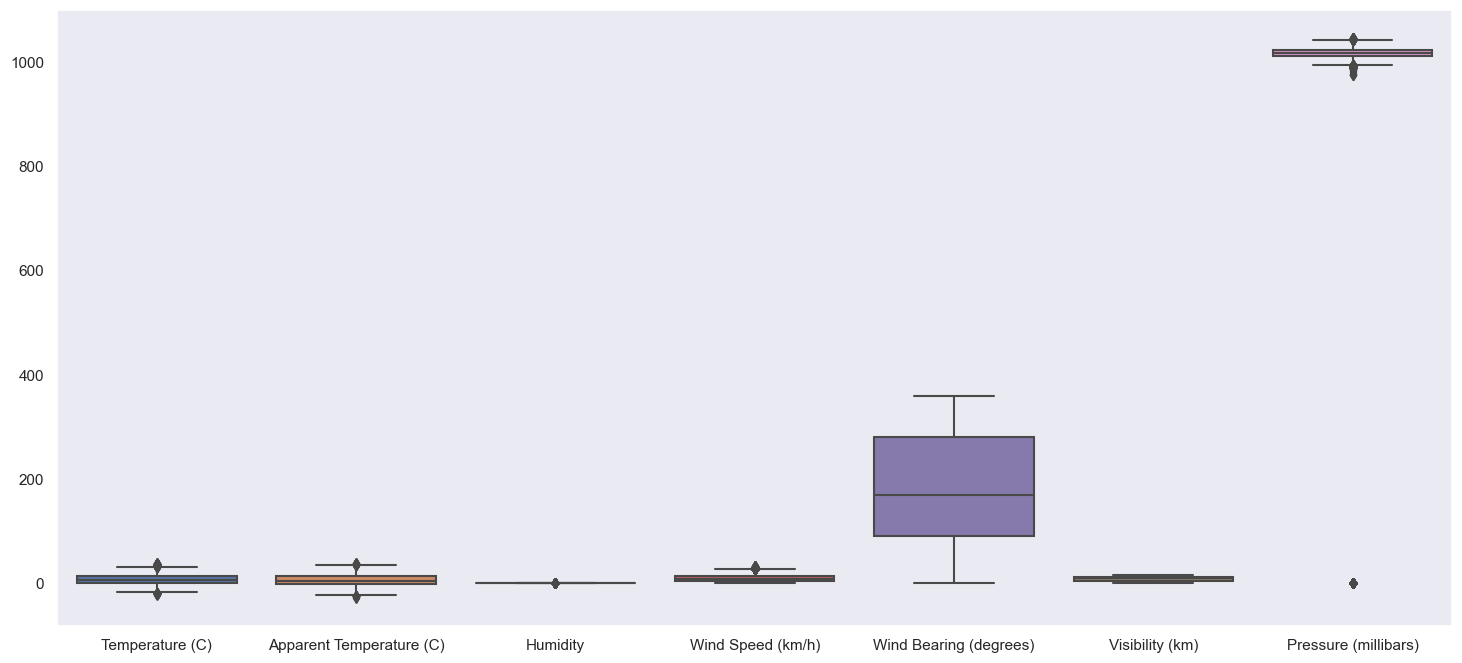

In [17]:
# Plotting for outliers in the data.
plt.figure(figsize=(18, 8)) 
sns.boxplot(data=data[numeric_columns])
plt.show()

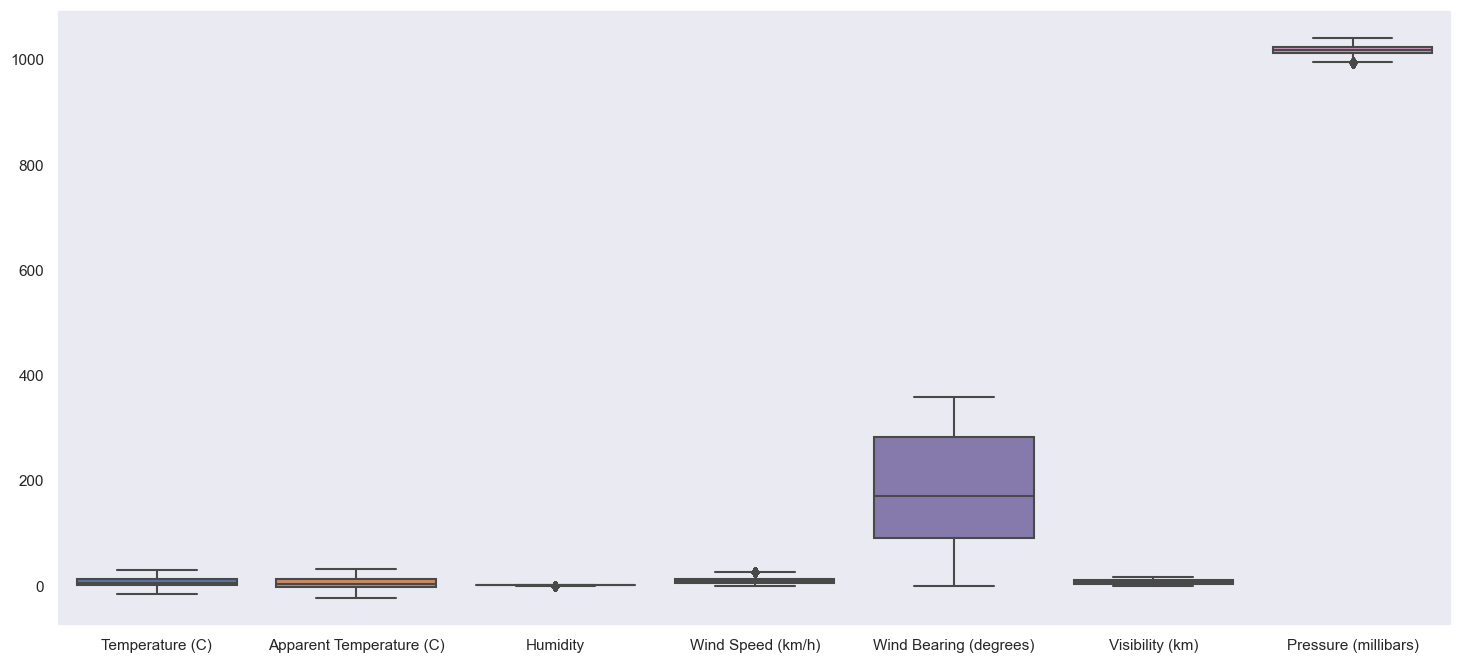

In [18]:
# Removing Outliers
data = remove_outliers(data, "Pressure (millibars)")
data = remove_outliers(data, "Wind Speed (km/h)")
data = remove_outliers(data, "Humidity")
data = remove_outliers(data, "Temperature (C)")
data = remove_outliers(data, "Apparent Temperature (C)")

plt.figure(figsize=(18, 8)) 
sns.boxplot(data=data[numeric_columns])
plt.show()

---

### 3. Exploratory Data Analysis

* #### Checking skewness of the numerical features

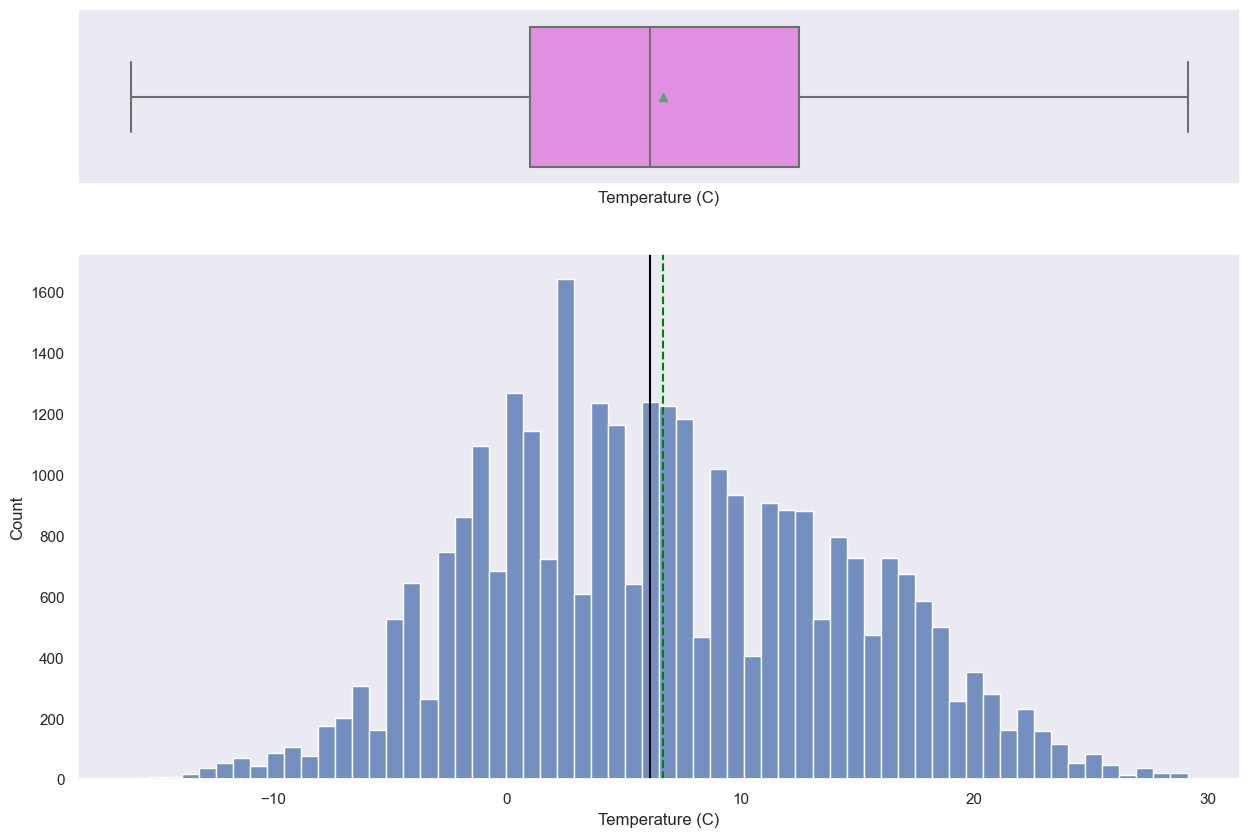

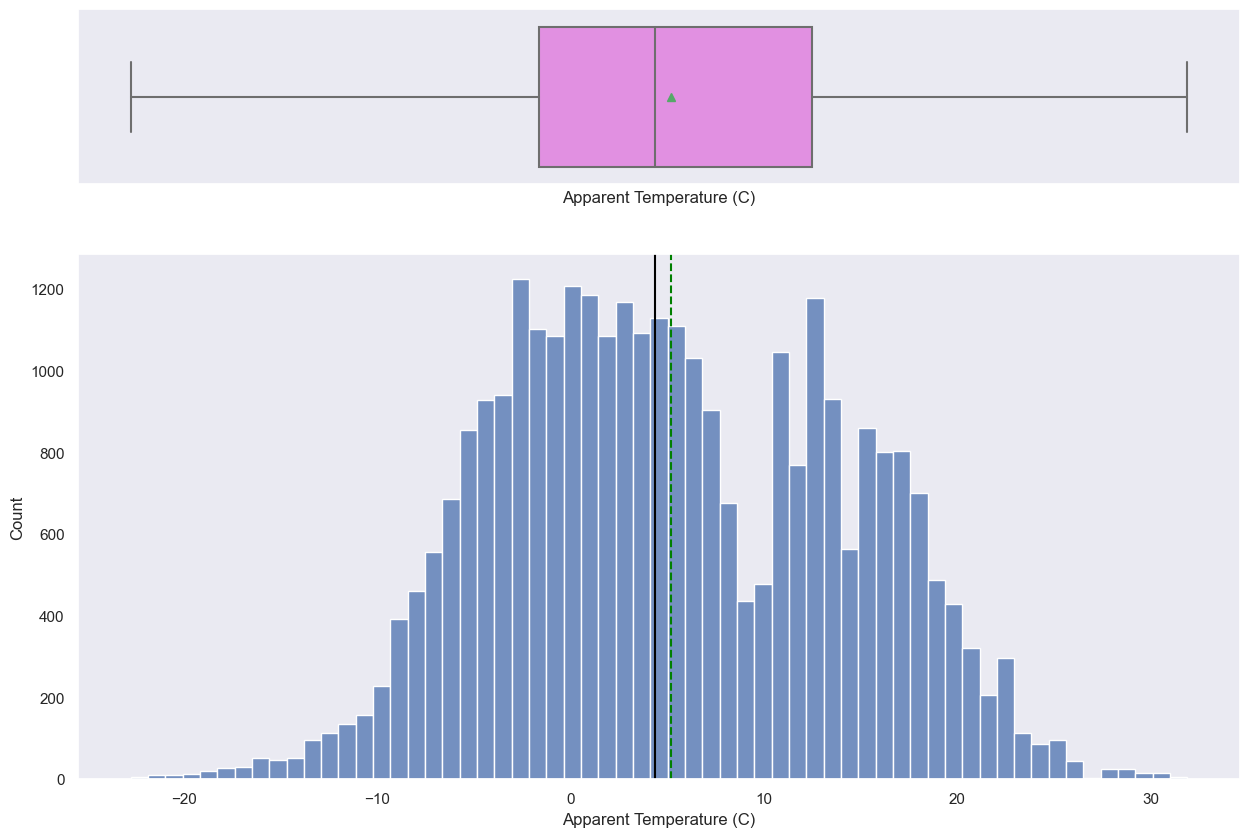

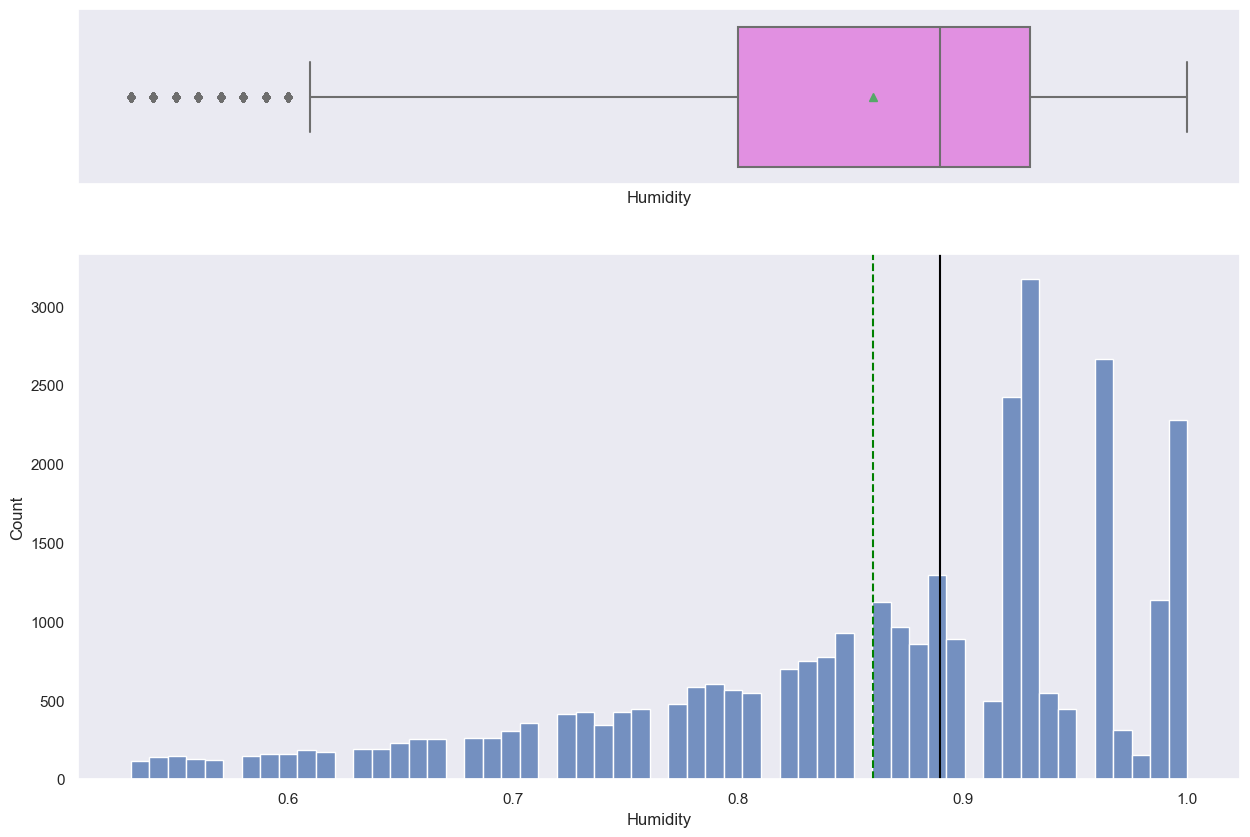

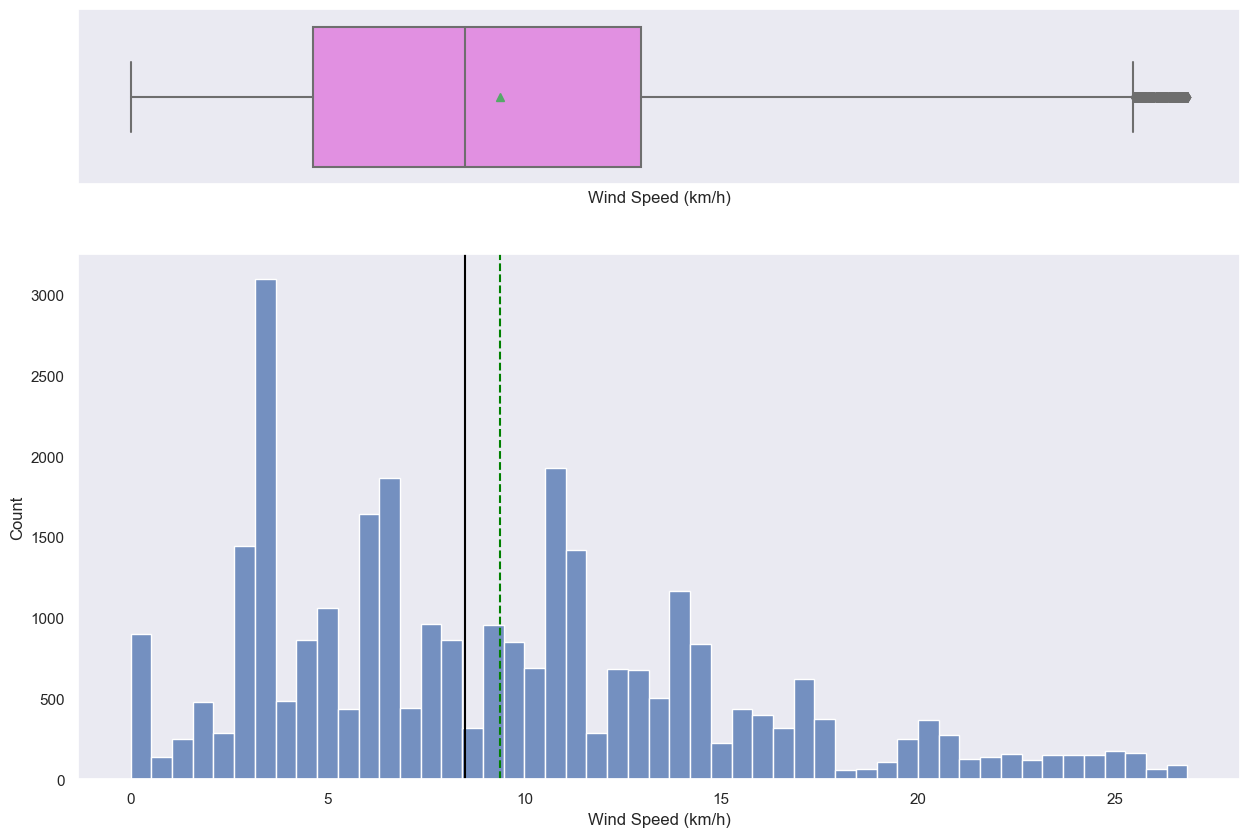

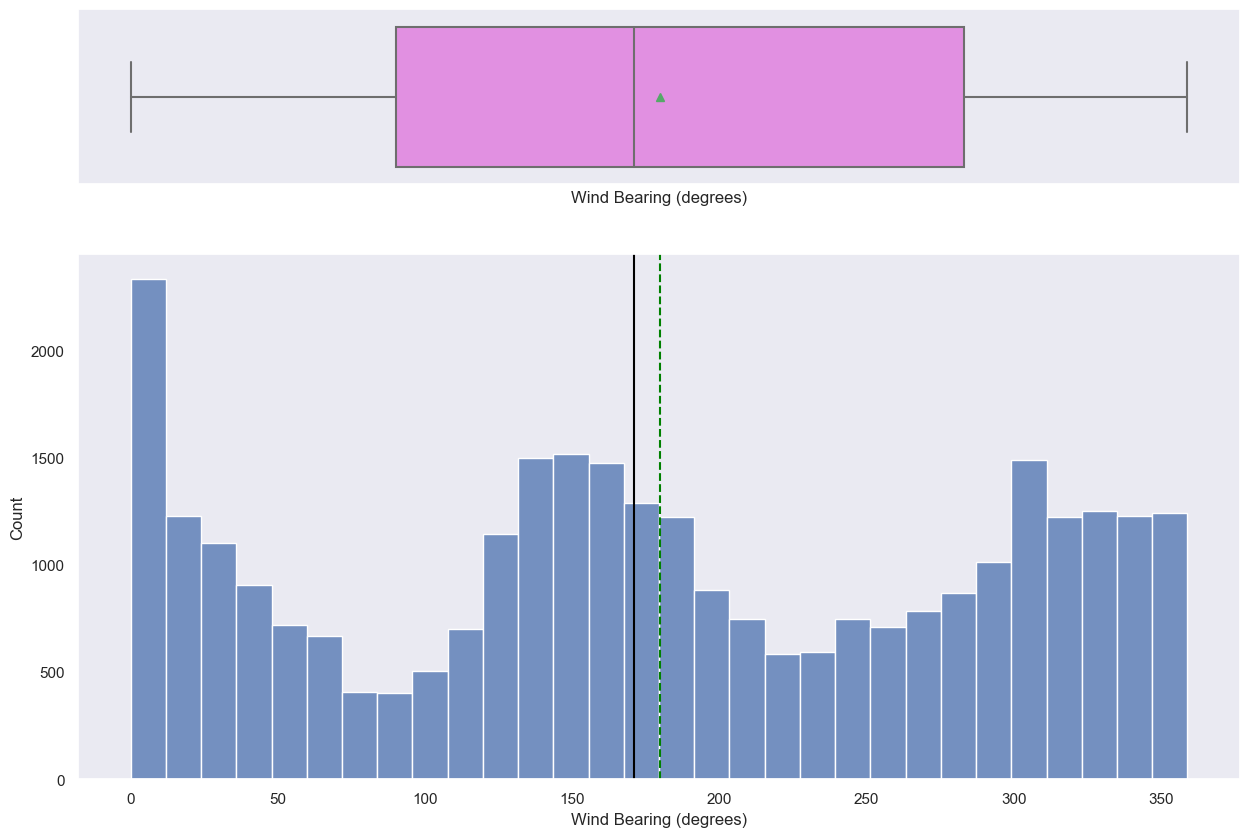

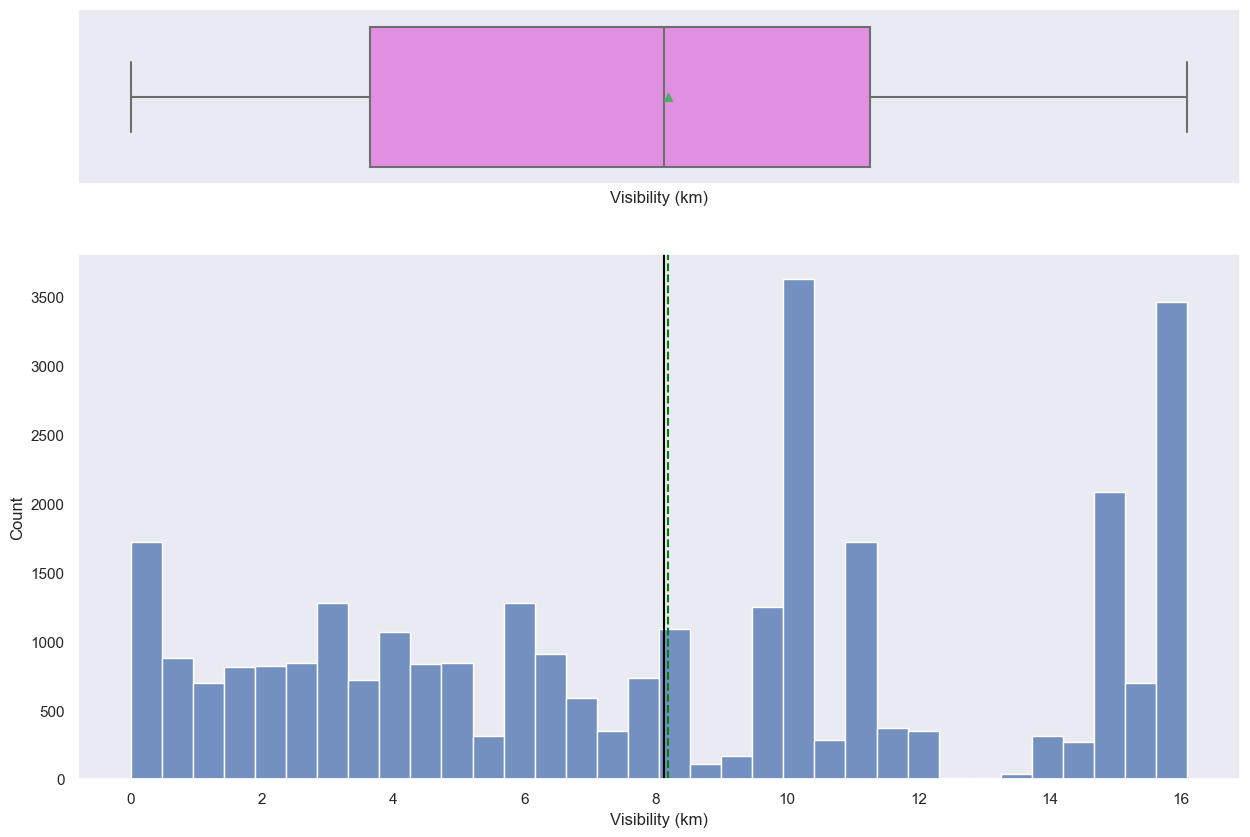

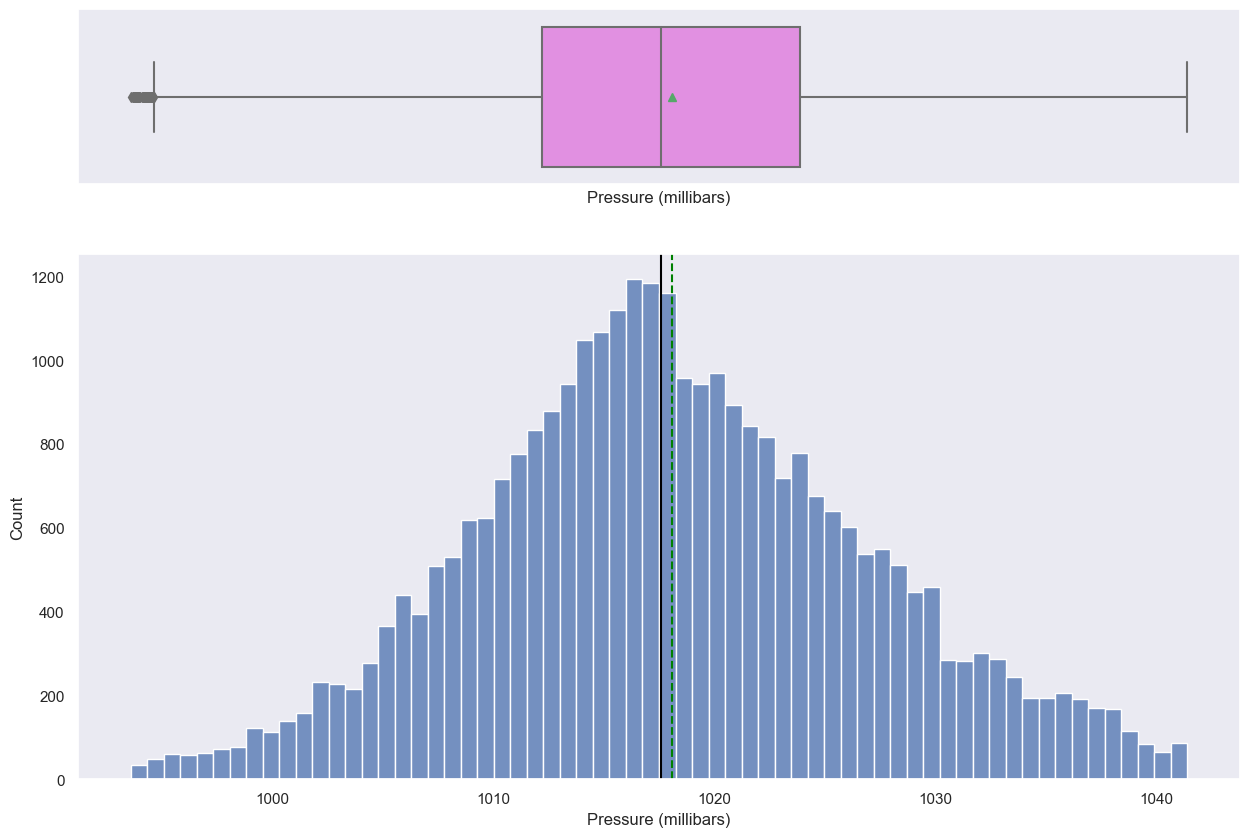

In [19]:
# Numerical columns analysis
for i in numeric_columns:
    histogram_boxplot(data,i)

* #### Checking distribution of categorical features(Summary and Precip Type)

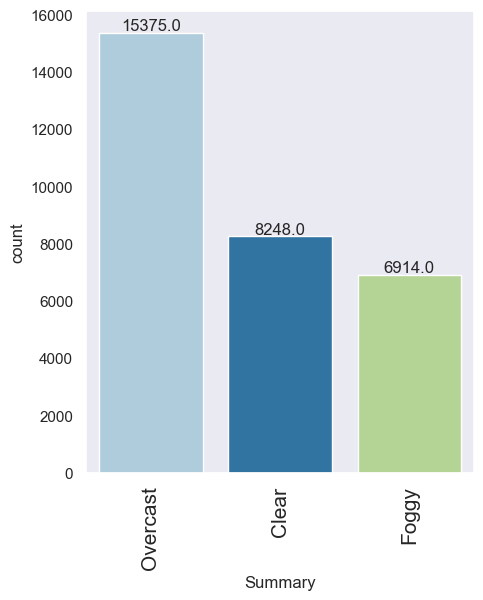

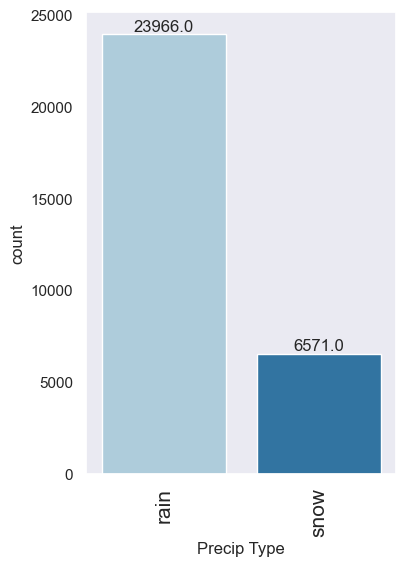

In [20]:
# Categorical columns analysis
for i in categorical_columns:
    if i in ['Daily Summary','Time']:
        pass
    else:
        labeled_barplot(data, i)

* #### Creating Word Cloud for 'daily summary'

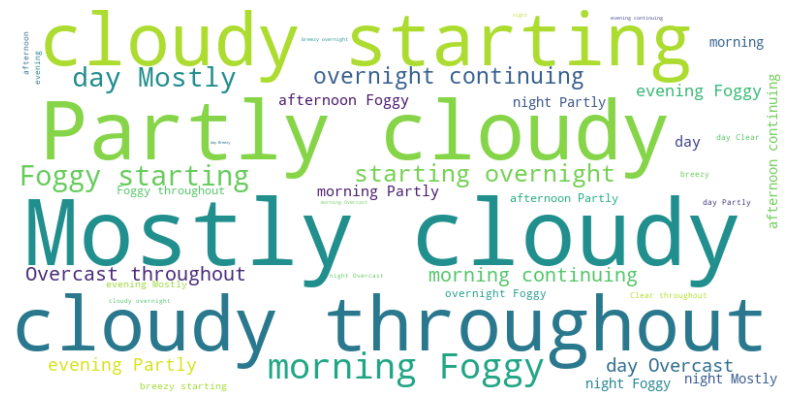

In [21]:
# Creating Word Cloud for daily summary
text = ' '.join(data['Daily Summary'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* #### Relations between numerical features & Target variable "Summary"

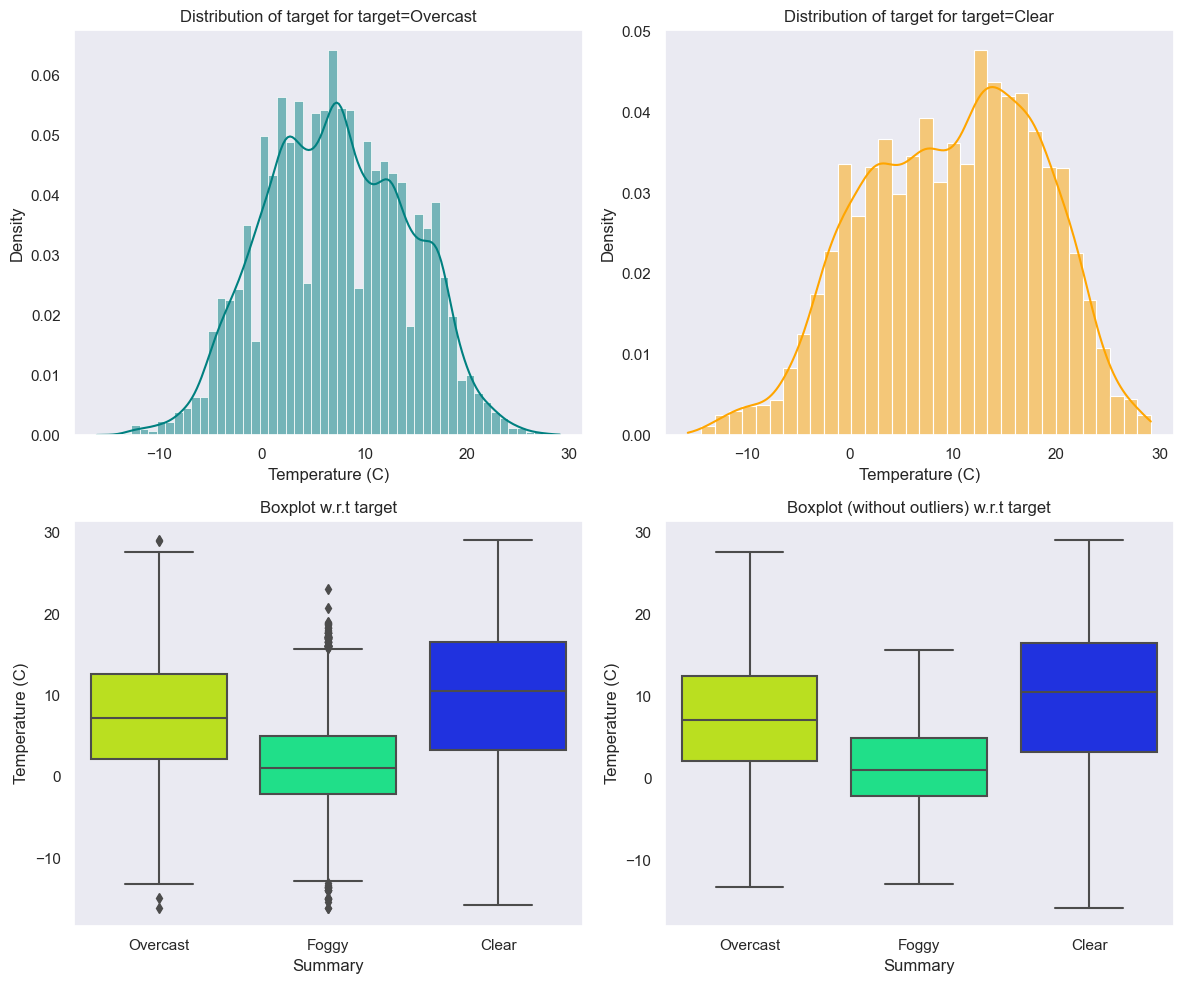

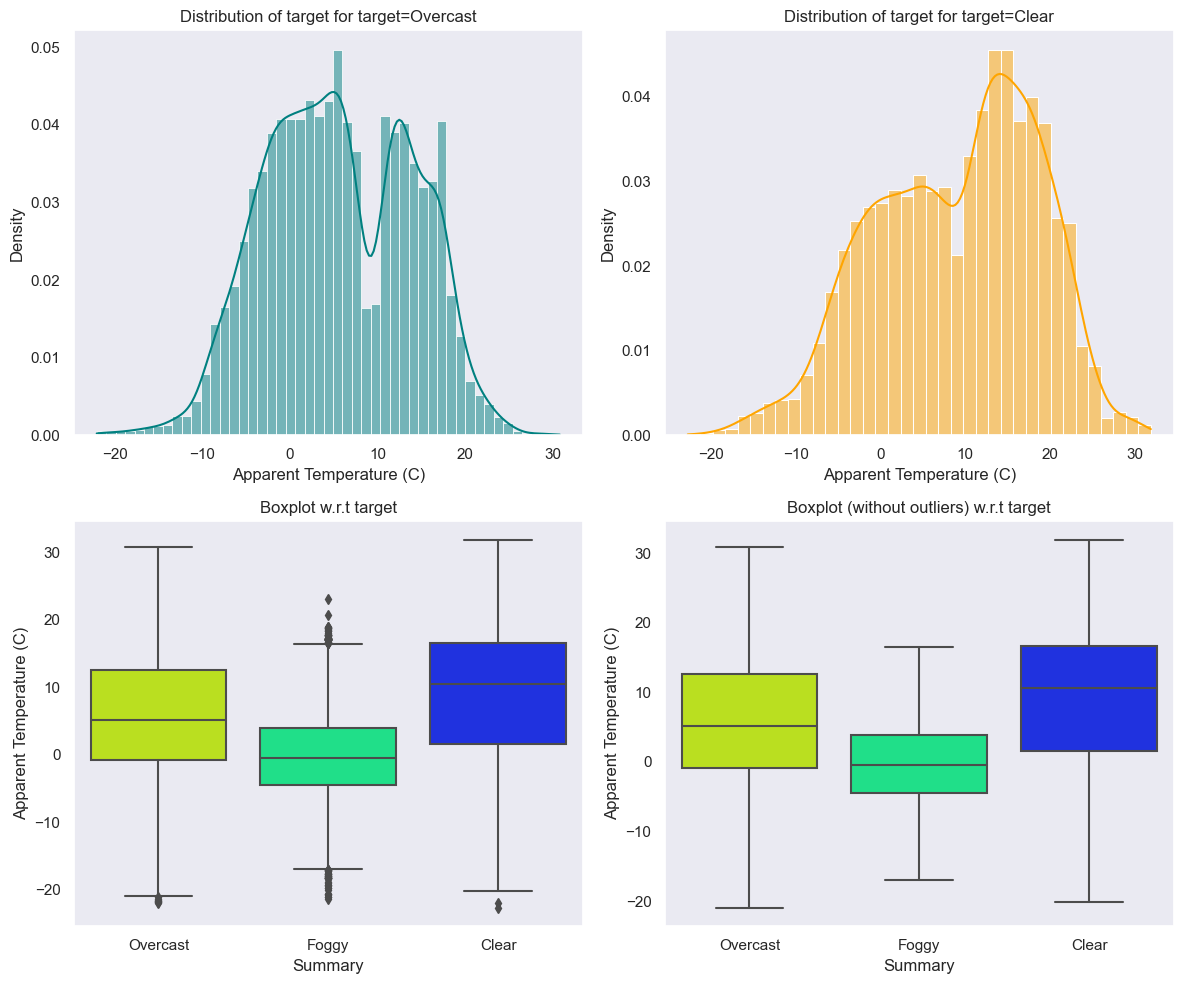

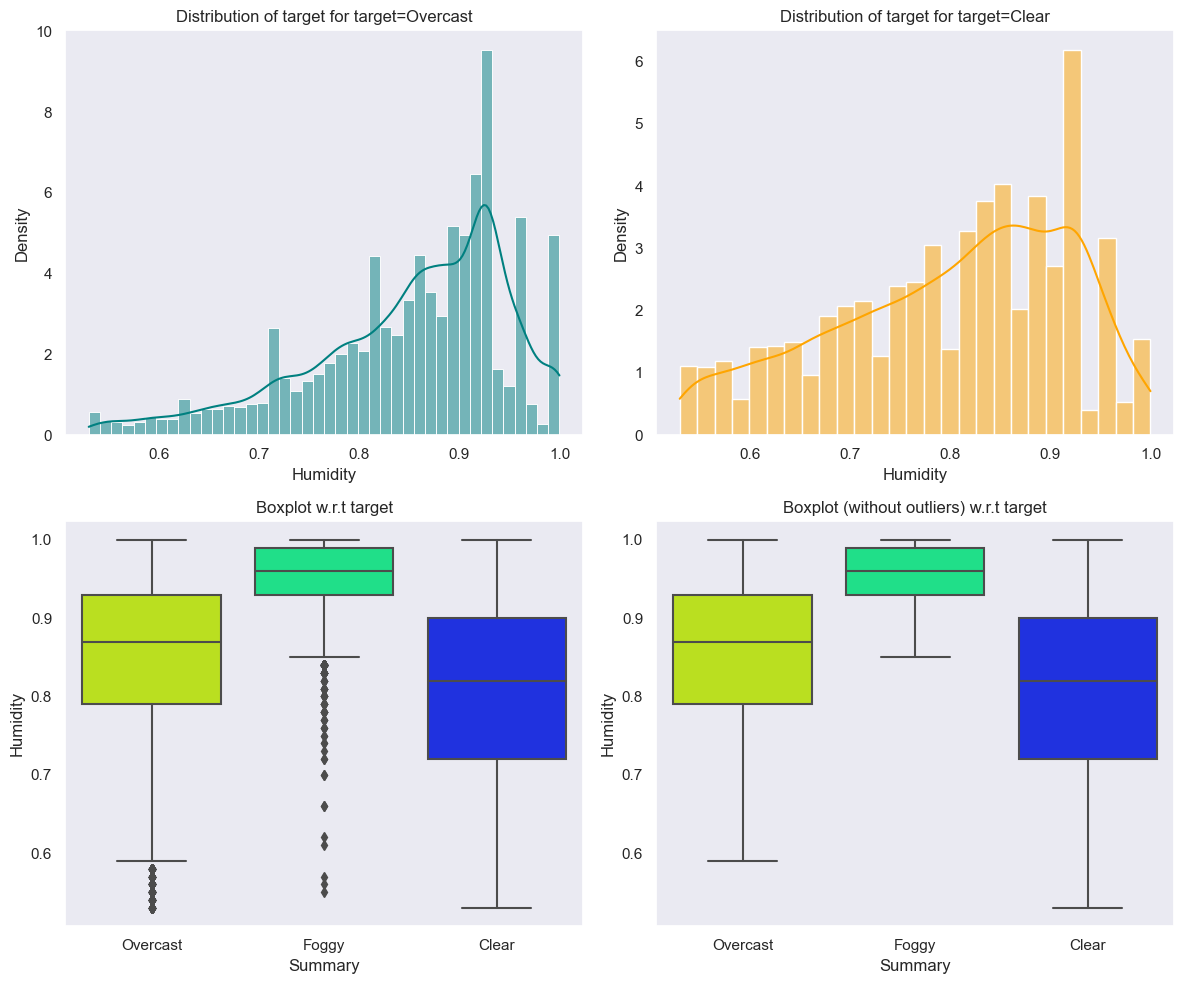

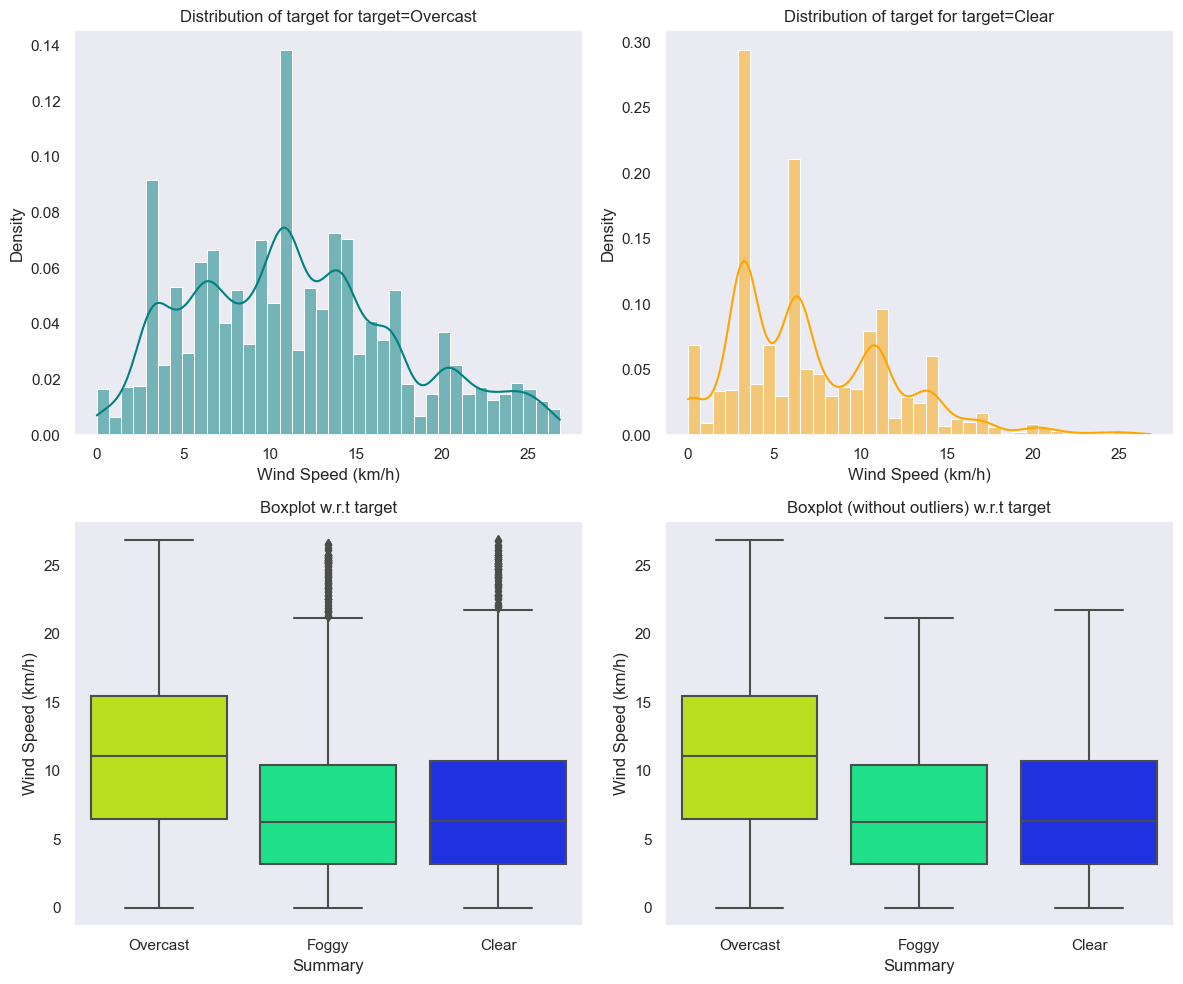

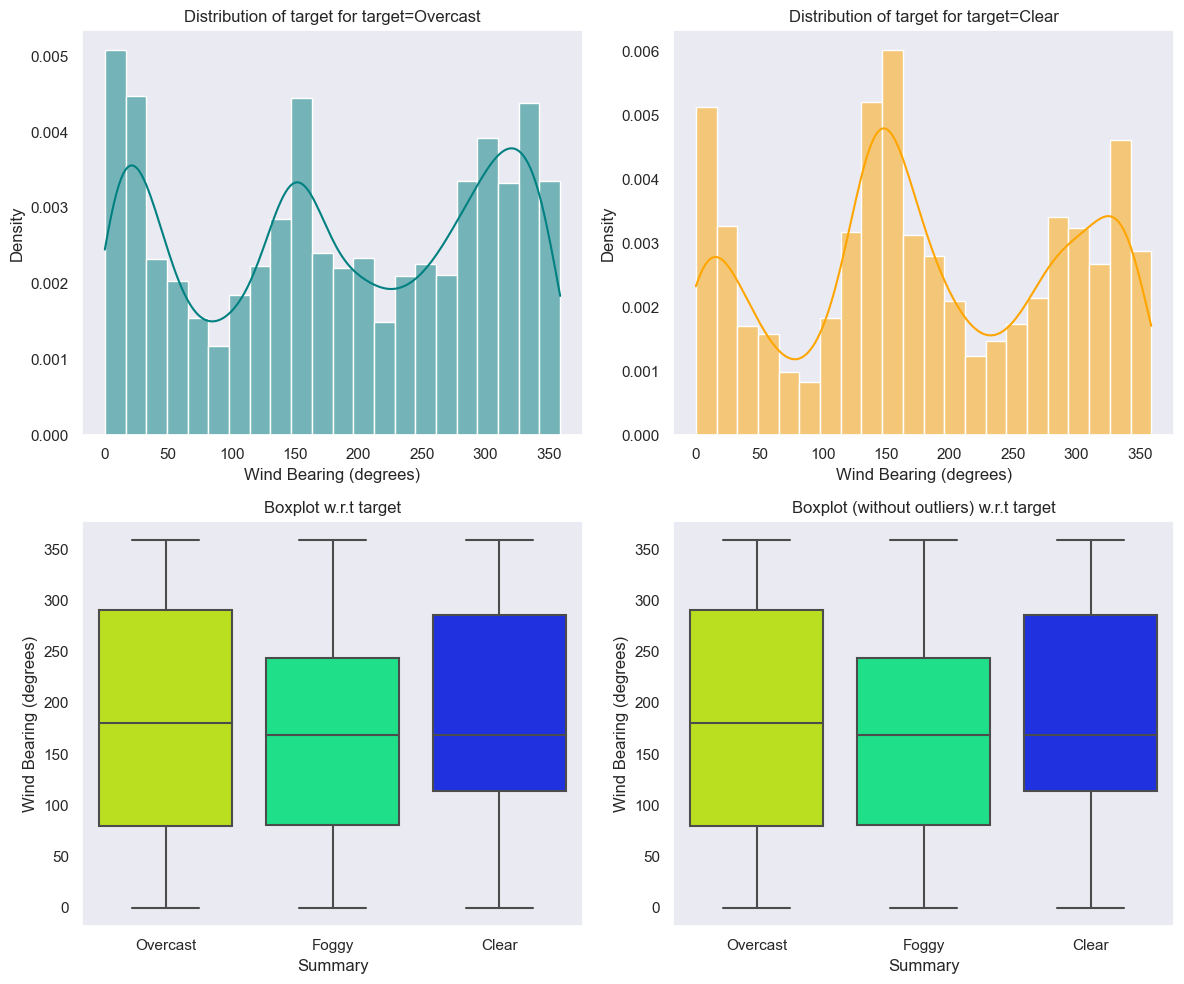

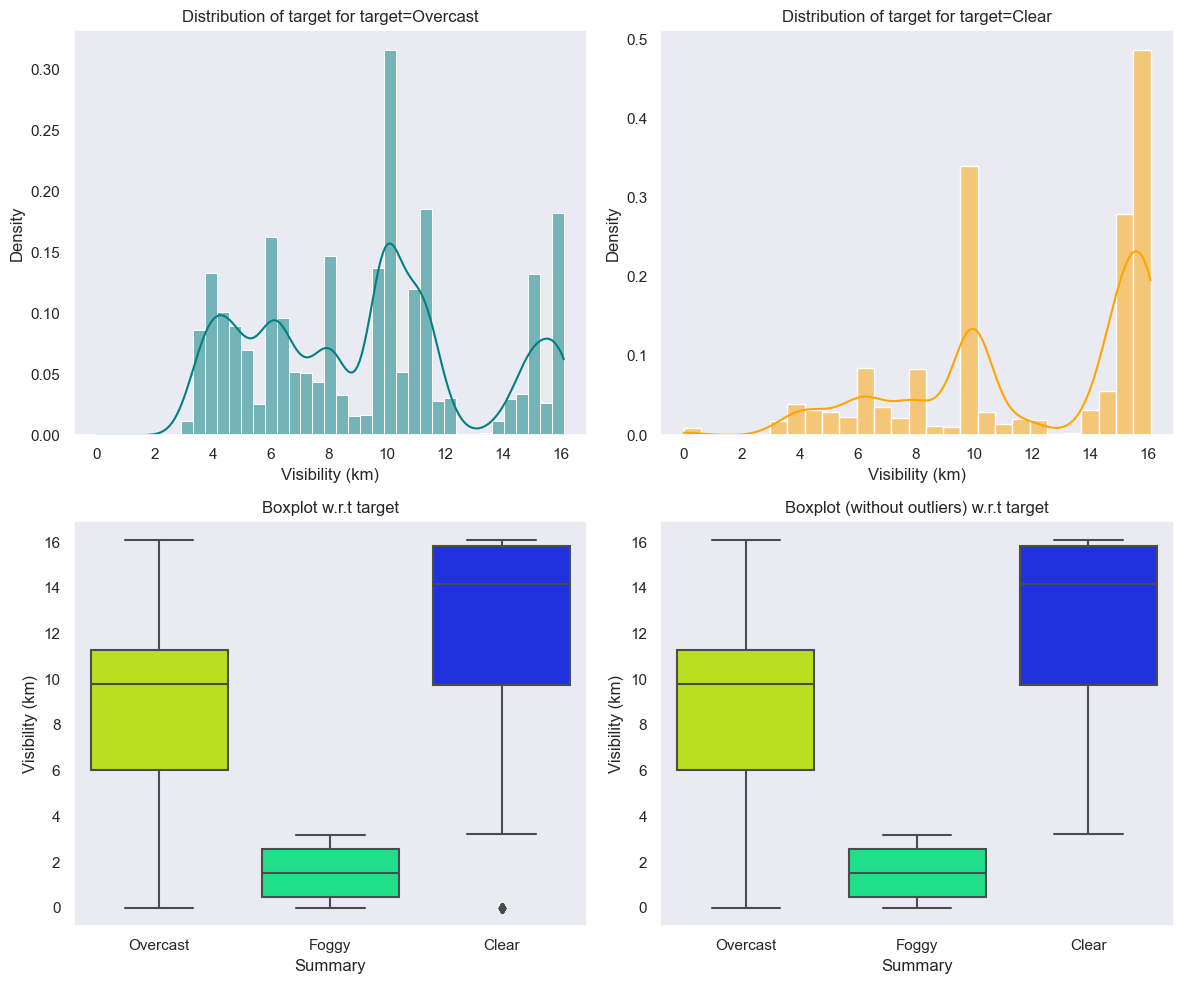

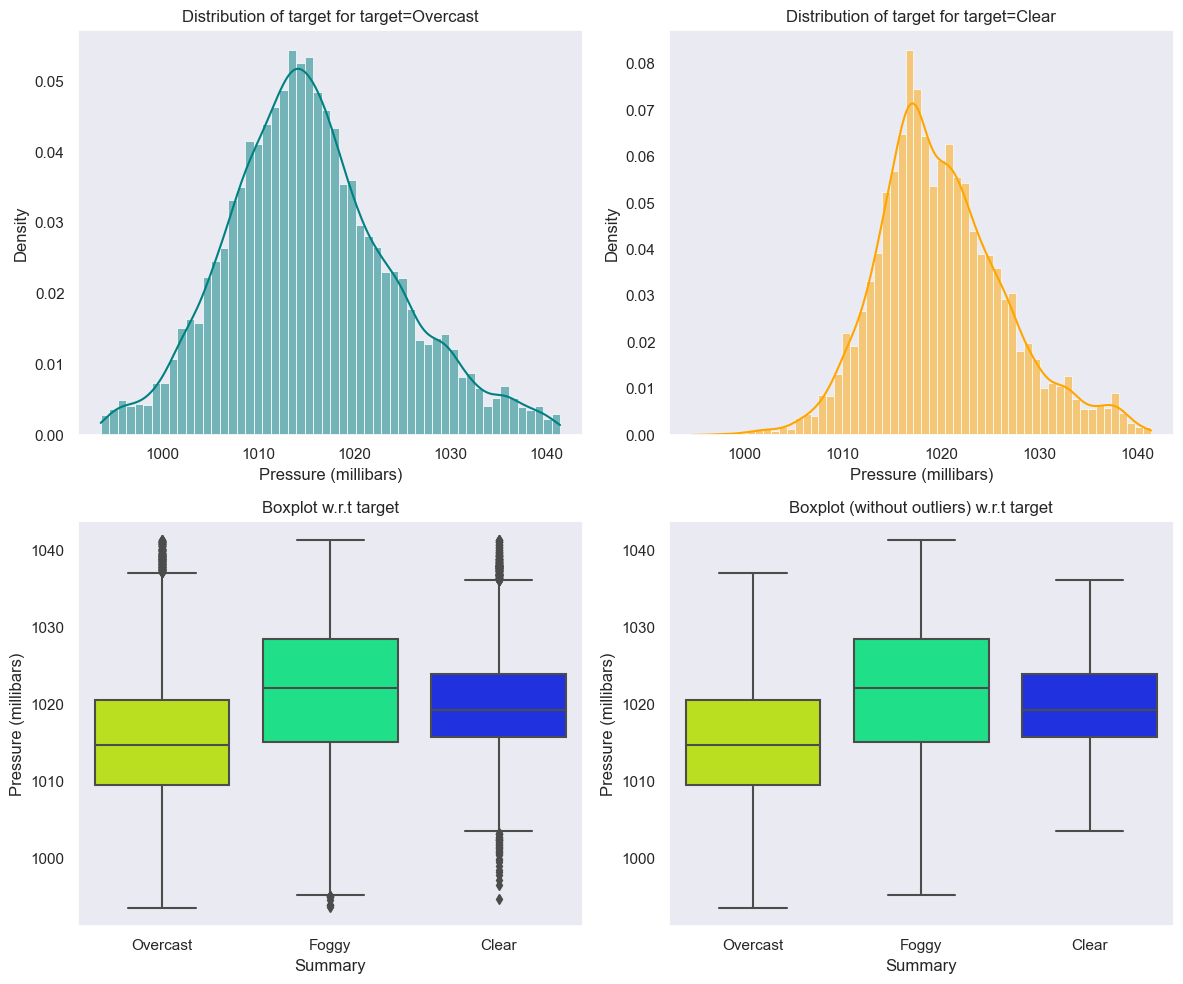

In [22]:
# Multivariate analysis
for i in numeric_columns:
    distribution_plot_wrt_target(data, i, "Summary")

* #### Relations between categorical features & Target variable "Summary"

Summary      Clear  Foggy  Overcast    All
Precip Type                               
All           8248   6914     15375  30537
rain          7052   4025     12889  23966
snow          1196   2889      2486   6571
------------------------------------------------------------------------------------------------------------------------


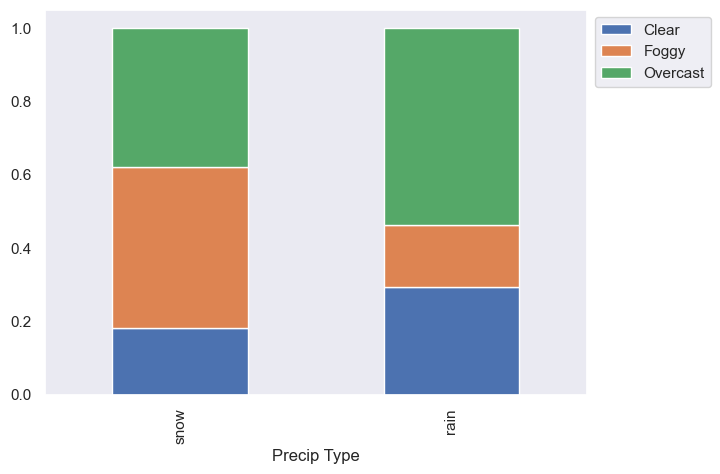

In [24]:
# Stacked barplot
stacked_barplot(data,"Precip Type" , 'Summary')

---

### 4. Data Pre-processing & Feature Engineering

* #### Classes Distribution

In [23]:
# Checking whether the target variable is balanced or unbalanced
counts = data["Summary"].value_counts()
total = counts.sum()
percentages = (counts / total) * 100
print(percentages)
print()
print("The classes are satifactory balanced")

Overcast    50.348757
Clear       27.009857
Foggy       22.641386
Name: Summary, dtype: float64

The classes are satifactory balanced


* #### Dataset Split

In [24]:
# Input features dataset
input_df = data.drop(columns="Summary", axis=1)
input_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Time,Year,Month,Day
46,rain,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,Mostly cloudy throughout the day.,22,2006,4,10
47,rain,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,Mostly cloudy throughout the day.,23,2006,4,10
48,rain,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,Foggy in the evening.,0,2006,4,11
49,rain,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,Foggy in the evening.,1,2006,4,11
50,rain,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,Foggy in the evening.,2,2006,4,11


In [25]:
# Target variable 
# Applying mapping
encoder = LabelEncoder()
y = data["Summary"]
y = encoder.fit_transform(y)

# Checking the mapping of the classes
class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
for class_label, class_number in class_mapping.items():
    print(f"Class '{class_label}' is labeled as {class_number}")

Class 'Clear' is labeled as 0
Class 'Foggy' is labeled as 1
Class 'Overcast' is labeled as 2


* #### Categorical Features Encoding

In [26]:
# As "Precip Type" have only 2 values, hence applying binary encoding
mapping = {'rain': 0, 'snow': 1}
input_df['Precip Type'] = input_df['Precip Type'].map(mapping)

In [27]:
# As "Daily Summary" have 221 unique values, hence applying Frequency encoding
# Creating a new column for frequency encoding and removing previous column
input_df['Daily Summary Frequency'] = input_df['Daily Summary'].map(input_df['Daily Summary'].value_counts(normalize=True))
input_df.drop(columns=['Daily Summary'], axis=1, inplace=True)
# Checking data
input_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Time,Year,Month,Day,Daily Summary Frequency
46,0,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,22,2006,4,10,0.177457
47,0,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,23,2006,4,10,0.177457
48,0,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,0,2006,4,11,0.004617
49,0,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,1,2006,4,11,0.004617
50,0,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,2,2006,4,11,0.004617


* #### Checking Multicollinearity

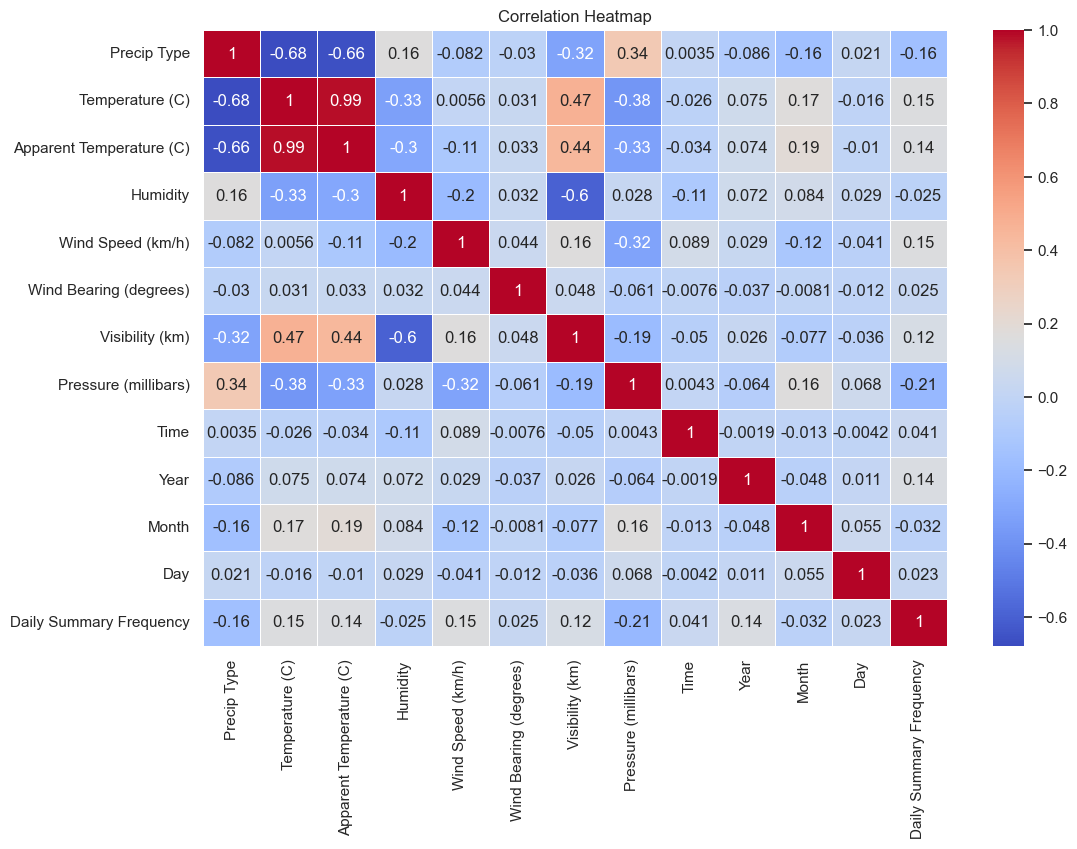

In [28]:
# Confirming multicollinearity using heatmap
sns.set(style="white")
plt.figure(figsize=(12,8))
sns.heatmap(input_df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [29]:
# As Daily Summary Frequency has a negligible correlation with the other features and it is apparent that the final target is not going to be affected by this, removing it.
input_df.drop(['Daily Summary Frequency'], axis=1, inplace=True)

In [30]:
# As VIF of Temperature (C) is the highest and Temperature is highly correlated with Apparent Temperature, removing it
input_df.drop(['Temperature (C)'], axis=1, inplace=True)

* #### Train-Test Split

In [31]:
# Creating X input set
X = input_df.values
X

array([[0.000e+00, 1.442e+01, 5.800e-01, ..., 2.006e+03, 4.000e+00,
        1.000e+01],
       [0.000e+00, 1.426e+01, 5.900e-01, ..., 2.006e+03, 4.000e+00,
        1.000e+01],
       [0.000e+00, 1.377e+01, 6.000e-01, ..., 2.006e+03, 4.000e+00,
        1.100e+01],
       ...,
       [0.000e+00, 1.502e+01, 9.000e-01, ..., 2.016e+03, 9.000e+00,
        9.000e+00],
       [0.000e+00, 1.387e+01, 9.300e-01, ..., 2.016e+03, 9.000e+00,
        9.000e+00],
       [0.000e+00, 1.607e+01, 8.800e-01, ..., 2.016e+03, 9.000e+00,
        9.000e+00]])

In [32]:
# Splitting the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

* #### Normalizing Input Features

In [33]:
# Apply scaling on the input_df DataFrame
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

---

### 5. Model Building

* #### Parametric Algorithm 1: Logistic Regression Classifier

In [38]:
# Hyperparameter tuning
parameters = {'solver': ['liblinear', 'saga'], 
              'multi_class':['ovr', 'multinomial'],
              'C':[0.001, 0.01, 10.0],
              'penalty': ['l1', 'l2']}
# Model Creation and Training
model_lr = LogisticRegression(n_jobs=-1)
models_lr = GridSearchCV(estimator=model_lr, param_grid=parameters, cv=4)
models_lr.fit(x_train, y_train)
best_parameters = models_lr.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions for train
best_model_lr = models_lr.best_estimator_
y_pred_lr = best_model_lr.predict(x_train)
# Predictions for test
y_pred_lr_new = best_model_lr.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_lr, y_test, y_pred_lr_new)

Best Hyperparameters: {'C': 10.0, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Logistic Regression

Accuracy: 0.834
Precision: 0.83
Recall: 0.834
F1 Score: 0.83



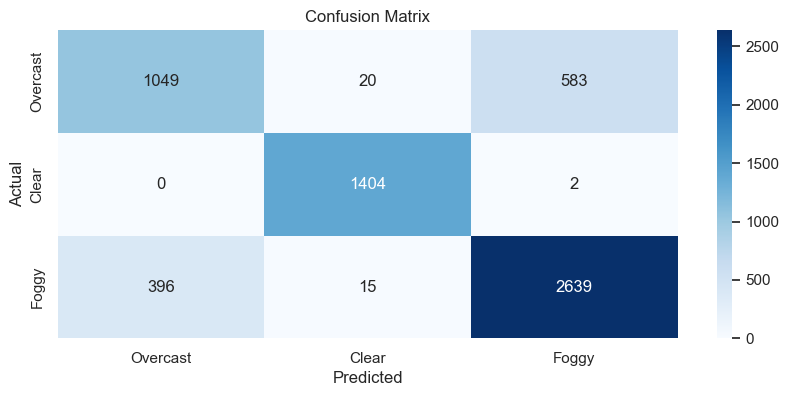

In [39]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_lr, precision_lr, recall_lr, f1_lr = calculate_classification_metrics(y_test, y_pred_lr_new, "Logistic Regression")

* #### Parametric Algorithm 2: Gaussian Naive Bayes Classifier

In [40]:
# Hyperparameter tuning
parameters = {'var_smoothing':[1e-9, 1e-8, 1e-10]}
# Model Creation and Training
model_nb = GaussianNB()
models_nb = GridSearchCV(estimator=model_nb, param_grid=parameters, cv=4)
models_nb.fit(x_train, y_train)
best_parameters = models_nb.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on training data
best_model_nb = models_nb.best_estimator_
y_pred_nb = best_model_nb.predict(x_train)
# Predictions on test data
y_pred_nb_new = best_model_nb.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_nb, y_test, y_pred_nb_new)

Best Hyperparameters: {'var_smoothing': 1e-09}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Gaussian NB

Accuracy: 0.795
Precision: 0.792
Recall: 0.795
F1 Score: 0.792



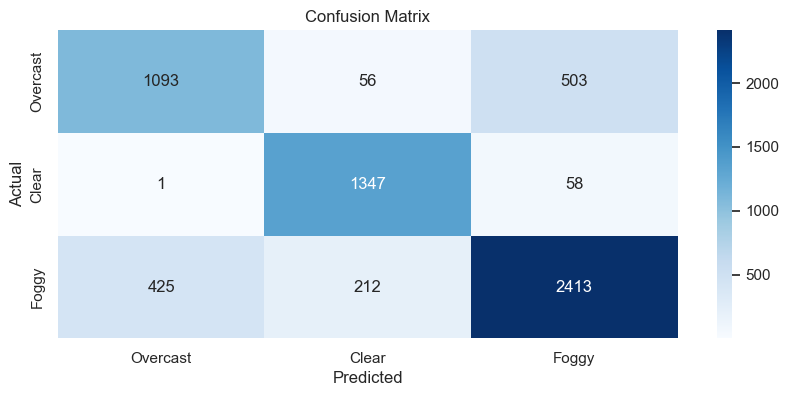

In [41]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_nb, precision_nb, recall_nb, f1_nb = calculate_classification_metrics(y_test, y_pred_nb_new, "Gaussian NB")

* #### Parametric Algorithm 3: Support Vector Machine (SVM) Classifier

In [42]:
# Hyperparameter tuning
parameters = {'loss':['log_loss','perceptron','hinge','squared_epsilon_insensitive'],
              'penalty': ['l1', 'l2'],
              'alpha':[0.001,0.01,0.0001],
              'learning_rate':['optimal','adaptive','invscaling']}
# Model Creation and Training
model_svc = SGDClassifier()
models_svc = GridSearchCV(estimator=model_svc, param_grid=parameters, cv=4)
models_svc.fit(x_train, y_train)
best_parameters = models_svc.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_svc = models_svc.best_estimator_
y_pred_svc = best_model_svc.predict(x_train)
# Predictions on test data
y_pred_svc_new = best_model_svc.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_svc, y_test, y_pred_svc_new)

Best Hyperparameters: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l1'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  SVC

Accuracy: 0.827
Precision: 0.824
Recall: 0.827
F1 Score: 0.825



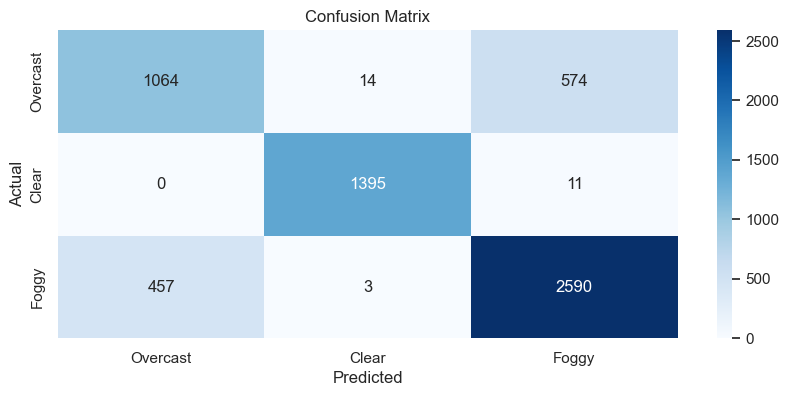

In [43]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_svc, precision_svc, recall_svc, f1_svc = calculate_classification_metrics(y_test, y_pred_svc_new, "SVC")

* #### Parametric Algorithm 4: SGD Classifier

In [44]:
# Hyperparameter tuning
parameters = {'loss':['log_loss','perceptron','hinge','squared_epsilon_insensitive'],
              'penalty': ['l1', 'l2'],
              'alpha':[0.001,0.01,0.0001],
              'learning_rate':['optimal','adaptive','invscaling']}
# Model Creation and Training
model_sgd = SGDClassifier()
models_sgd = GridSearchCV(estimator=model_sgd, param_grid=parameters, cv=4)
models_sgd.fit(x_train, y_train)
best_parameters = models_sgd.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_sgd = models_sgd.best_estimator_
y_pred_sgd = best_model_sgd.predict(x_train)
# Predictions on test data
y_pred_sgd_new = best_model_sgd.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_sgd, y_test, y_pred_sgd_new)

Best Hyperparameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l1'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  SGD Classifier

Accuracy: 0.824
Precision: 0.819
Recall: 0.824
F1 Score: 0.82



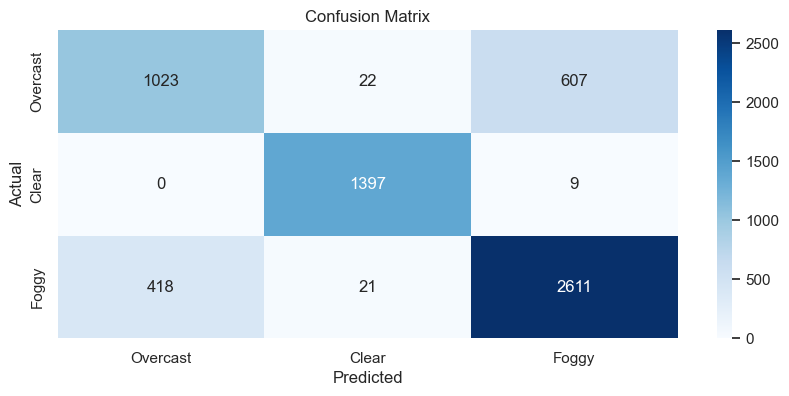

In [45]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = calculate_classification_metrics(y_test, y_pred_sgd_new, "SGD Classifier")

* #### Non-Parametric Algorithm 1: Decision Tree Classifier

In [46]:
# Hyperparameter tuning
parameters = {'criterion':['gini', 'entropy', 'log_loss'], 
              'max_depth': [None, 5, 10],
              'min_samples_split': [None, 2, 5],
              'splitter':['best','random']}
# Model Creation and Training
model_dt = DecisionTreeClassifier()
models_dt = GridSearchCV(estimator=model_dt, param_grid=parameters, cv=4)
models_dt.fit(x_train, y_train)
best_parameters = models_dt.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_dt = models_dt.best_estimator_
y_pred_dt = best_model_dt.predict(x_train)
# Predictions on test data
y_pred_dt_new = best_model_dt.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_dt, y_test, y_pred_dt_new)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'splitter': 'best'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Decision Tree

Accuracy: 0.889
Precision: 0.89
Recall: 0.889
F1 Score: 0.889



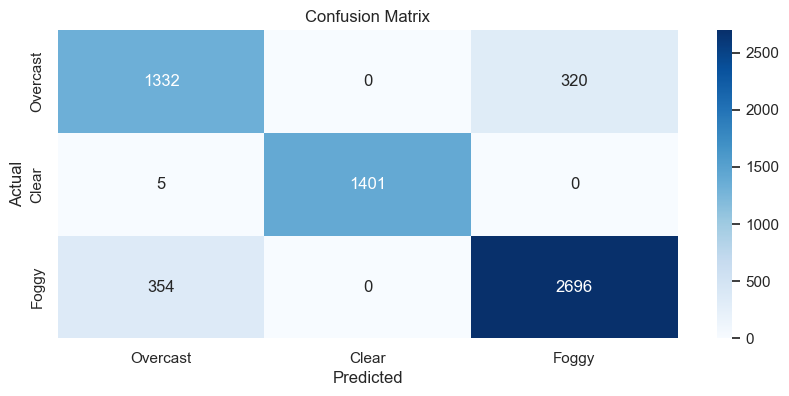

In [47]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_dt, precision_dt, recall_dt, f1_dt = calculate_classification_metrics(y_test, y_pred_dt_new, "Decision Tree")

* #### Non-Parametric Algorithm 2: K Nearest Neighbours Classifier

In [48]:
# Hyperparameter tuning
parameters = {'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree','kd_tree','brute'],
            'p': [1,2]}
# Model Creation and Training
model_knn = KNeighborsClassifier(n_neighbors=5)
models_knn = GridSearchCV(estimator=model_knn, param_grid=parameters, cv=4)
models_knn.fit(x_train, y_train)
best_parameters = models_knn.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_knn = models_knn.best_estimator_
y_pred_knn = best_model_knn.predict(x_train)
# Predictions on test data
y_pred_knn_new = best_model_knn.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_knn, y_test, y_pred_knn_new)

Best Hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  KNN

Accuracy: 0.905
Precision: 0.905
Recall: 0.905
F1 Score: 0.905



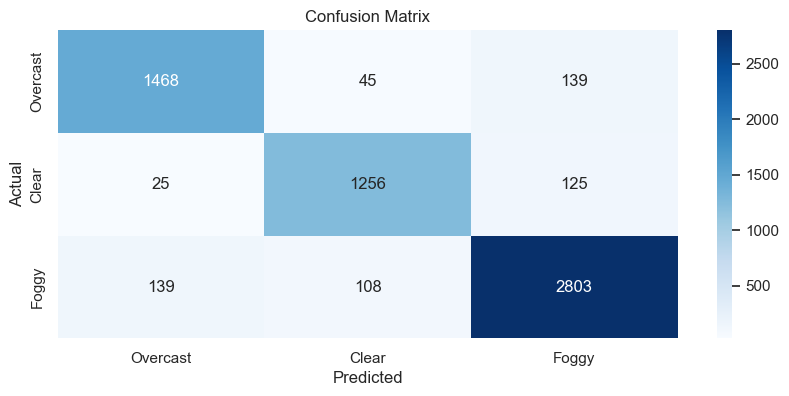

In [49]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_knn, precision_knn, recall_knn, f1_knn = calculate_classification_metrics(y_test, y_pred_knn_new, "KNN")

* #### Non-Parametric Algorithm 3: Random Forest Classifier

In [50]:
# Hyperparameter tuning
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5]}
# Model Creation and Training
model_rf = RandomForestClassifier()
models_rf = GridSearchCV(estimator=model_rf, param_grid=parameters, cv=4)
models_rf.fit(x_train, y_train)
best_parameters = models_rf.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_rf = models_rf.best_estimator_
y_pred_rf = best_model_rf.predict(x_train)
# Predictions on test data
y_pred_rf_new = best_model_rf.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_rf, y_test, y_pred_rf_new)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Random Forest

Accuracy: 0.939
Precision: 0.939
Recall: 0.939
F1 Score: 0.939



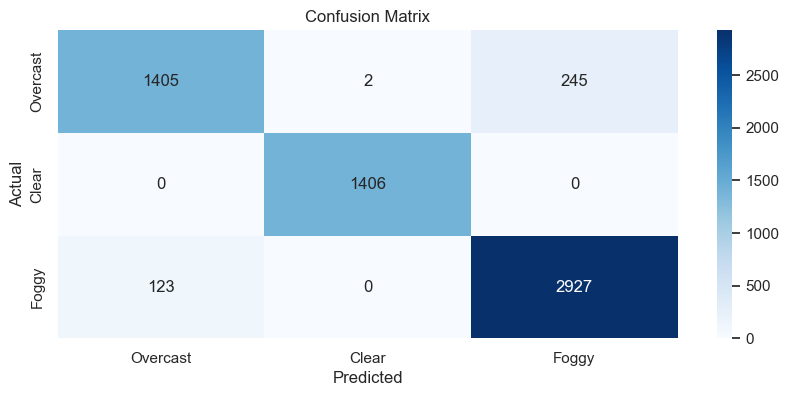

In [51]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_rf, precision_rf, recall_rf, f1_rf = calculate_classification_metrics(y_test, y_pred_rf_new, "Random Forest")

* #### Non-Parametric Algorithm 4: Extra Trees Classifier

In [52]:
# Hyperparameter tuning
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5],
            'criterion':['gini','log_loss','entropy']}
# Model Creation and Training
model_et = ExtraTreesClassifier()
models_et = GridSearchCV(estimator=model_et, param_grid=parameters, cv=4)
models_et.fit(x_train, y_train)
best_parameters = models_et.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_et = models_et.best_estimator_
y_pred_et = best_model_et.predict(x_train)
# Predictions on test data
y_pred_et_new = best_model_et.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_et, y_test, y_pred_et_new)

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Extra Trees

Accuracy: 0.947
Precision: 0.947
Recall: 0.947
F1 Score: 0.946



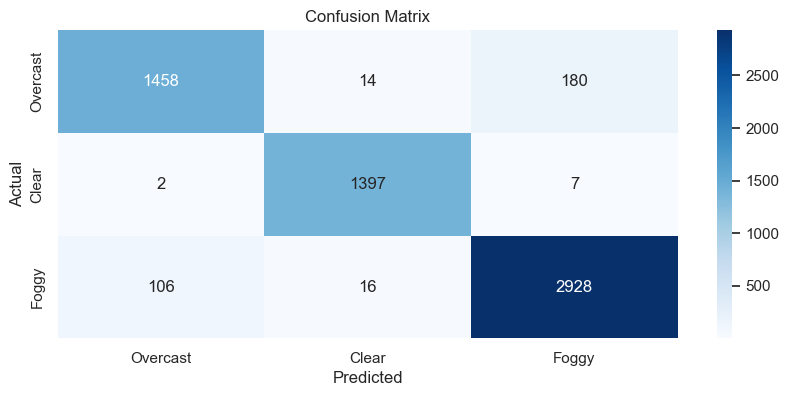

In [53]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_et, precision_et, recall_et, f1_et = calculate_classification_metrics(y_test, y_pred_et_new, "Extra Trees")

* #### Non-Parametric Algorithm 5: Gradient Boosting Classifier

In [36]:
# Hyperparameter tuning
parameters = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}
# Model creation and training
model_gb = GradientBoostingClassifier()
models_gb = GridSearchCV(estimator=model_gb, param_grid=parameters, cv=4)
models_gb.fit(x_train, y_train)
best_parameters = models_gb.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on the training data
best_model_gb = models_gb.best_estimator_
y_pred_gb = best_model_gb.predict(x_train)
# Predictions on the test data
y_pred_gb_new= best_model_gb.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_gb, y_test, y_pred_gb_new)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Gradient Boosting Classifier

Accuracy: 0.944
Precision: 0.944
Recall: 0.944
F1 Score: 0.944



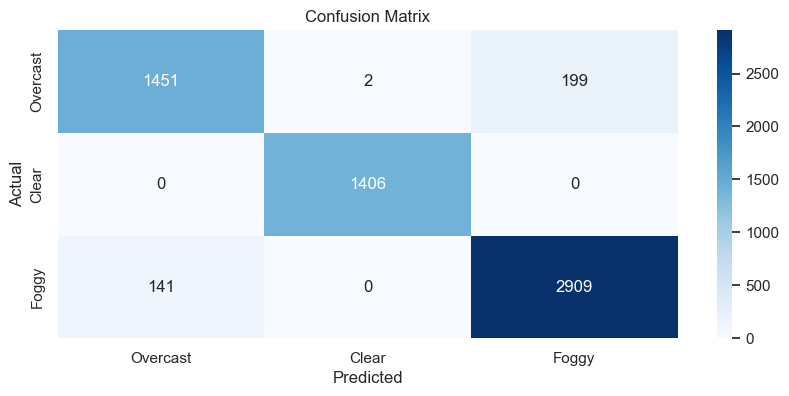

In [37]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_gb, precision_gb, recall_gb, f1_gb = calculate_classification_metrics(y_test, y_pred_gb_new, "Gradient Boosting Classifier")

* #### Non-Parametric Algorithm 6: Bagging Classifier

In [34]:
# Hyperparameter tuning
parameters = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9]
}
# Model creation and training
model_bagging = BaggingClassifier()
models_bagging = GridSearchCV(estimator=model_bagging, param_grid=parameters, cv=4)
models_bagging.fit(x_train, y_train)
best_parameters = models_bagging.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions for train
best_model_bagging = models_bagging.best_estimator_
y_pred_bagging = best_model_bagging.predict(x_train)
# Predictions for test
y_pred_bagging_new= best_model_bagging.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_bagging, y_test, y_pred_bagging_new)

Best Hyperparameters: {'max_features': 0.7, 'max_samples': 0.9, 'n_estimators': 100}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Bagging Classifier

Accuracy: 0.945
Precision: 0.945
Recall: 0.945
F1 Score: 0.945



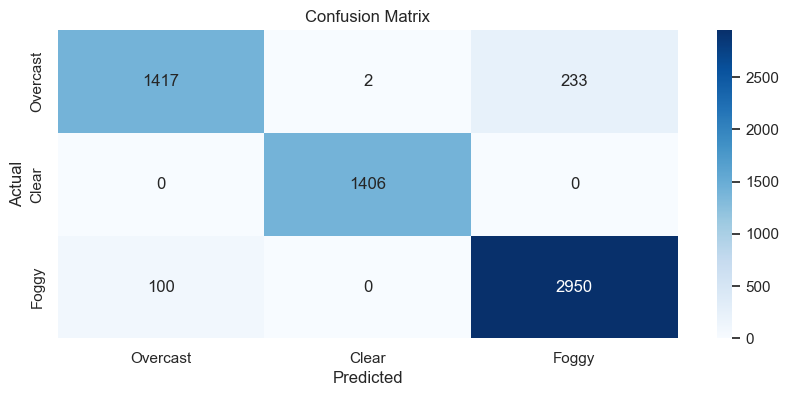

In [35]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_bc, precision_bc, recall_bc, f1_bc = calculate_classification_metrics(y_test, y_pred_bagging_new, "Bagging Classifier")

In [54]:
# Results
print("Testing Performances for Machine Learning Algorithms")
result = pd.DataFrame({"Algorithms":['Logistic Regression', "Gaussian Naive Bayes", "SVC", "SGD Classifier", "Decision Tree", "KNN","Random Forest", "Extra Trees Classifier", "Bagging Classifier","Gradient Boosting Classifier"],
                       "Accuracy":[accuracy_lr, accuracy_nb, accuracy_svc, accuracy_sgd, accuracy_dt, accuracy_knn, accuracy_rf, accuracy_et, accuracy_bc, accuracy_gb],
                       "Precision":[precision_lr, precision_nb, precision_svc, precision_sgd, precision_dt, precision_knn, precision_rf, precision_et, precision_bc, precision_gb],
                       "Recall":[recall_lr, recall_nb, recall_svc, recall_sgd, recall_dt, recall_knn, recall_rf, recall_et, recall_bc, recall_gb],
                       "F1 Score":[f1_lr, f1_nb, f1_svc, f1_sgd, f1_dt, f1_knn, f1_rf, f1_et, f1_bc, f1_gb]}).set_index('Algorithms')
result

Testing Performances for Machine Learning Algorithms


,Accuracy,Precision,Recall,F1 Score
Algorithms,,,,
Logistic Regression,0.834,0.830,0.834,0.830
Gaussian Naive Bayes,0.795,0.792,0.795,0.792
SVC,0.827,0.824,0.827,0.825
SGD Classifier,0.824,0.819,0.824,0.820
Decision Tree,0.889,0.890,0.889,0.889
KNN,0.905,0.905,0.905,0.905
Random Forest,0.939,0.939,0.939,0.939
Extra Trees Classifier,0.947,0.947,0.947,0.946
Bagging Classifier,0.945,0.945,0.945,0.945


In [55]:
# Saving sklearn machine learning models
models = [best_model_dt, best_model_lr, best_model_knn, best_model_et, best_model_nb, best_model_rf, best_model_sgd, best_model_svc, best_model_gb, best_model_bagging]
names = ["dt","lr","knn","et","nb","rf","sgd","svc","gb","bg"]
for i in range(len(models)):
    joblib.dump(models[i],names[i]+".pkl")

---

* #### Neural Network Preprocessing

In [58]:
# Hyperparameters for ANN & RNN
num_classes = 3
epochs = 150
input_dimension = x_train.shape[1]
batch_size = 64
learning_rate = 0.001

In [59]:
# Converting labels to one-hot encoded format
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes)

In [60]:
# Reshaping input data for RNN
x_train_reshaped = np.expand_dims(x_train, axis=2)
x_test_reshaped = np.expand_dims(x_test, axis=2)

* #### Neural Network 1: Feed Forward Neural Network

Epoch 1/150
382/382 [==============================] - 2s 2ms/step - loss: 0.4948 - accuracy: 0.7801 - val_loss: 0.3934 - val_accuracy: 0.8307
Epoch 2/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3852 - accuracy: 0.8288 - val_loss: 0.3551 - val_accuracy: 0.8450
Epoch 3/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3501 - accuracy: 0.8451 - val_loss: 0.3337 - val_accuracy: 0.8543
Epoch 4/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3291 - accuracy: 0.8560 - val_loss: 0.3312 - val_accuracy: 0.8548
Epoch 5/150
382/382 [==============================] - 1s 2ms/step - loss: 0.3120 - accuracy: 0.8650 - val_loss: 0.3073 - val_accuracy: 0.8676
Epoch 6/150
382/382 [==============================] - 1s 2ms/step - loss: 0.2999 - accuracy: 0.8718 - val_loss: 0.2958 - val_accuracy: 0.8744
Epoch 7/150
382/382 [==============================] - 1s 2ms/step - loss: 0.2901 - accuracy: 0.8753 - val_loss: 0.2932 - val_accuracy: 0.8739

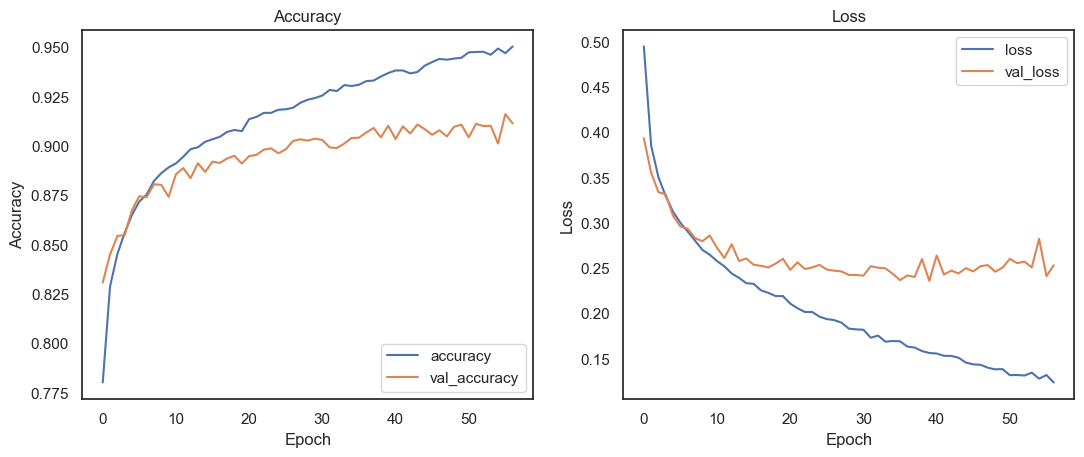

In [61]:
# Architecture 1: 64-64-128-3 Feed Forward Neural Network
# Defining the ANN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_dim=input_dimension)) 
model.add(tf.keras.layers.Dense(64, activation='relu')) 
model.add(tf.keras.layers.Dense(128, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(num_classes, activation='softmax')) 
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Stopping early to avoid overfitting
stop_callback = myCallback()

# Training
history = model.fit(x_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [62]:
# Evaluating the model on test data
test_loss_0, test_accuracy_0 = model.evaluate(x_test, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_0)
print('Test Accuracy:', test_accuracy_0)
# Saving the model to a file
model.save('FFNN.h5')

Test Loss: 0.252924382686615
Test Accuracy: 0.9112639427185059


Epoch 1/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0523 - accuracy: 0.4812 - val_loss: 1.0080 - val_accuracy: 0.5309
Epoch 2/150
382/382 [==============================] - 1s 2ms/step - loss: 0.9815 - accuracy: 0.5394 - val_loss: 0.9499 - val_accuracy: 0.5494
Epoch 3/150
382/382 [==============================] - 1s 2ms/step - loss: 0.9300 - accuracy: 0.5653 - val_loss: 0.9011 - val_accuracy: 0.5853
Epoch 4/150
382/382 [==============================] - 1s 2ms/step - loss: 0.8830 - accuracy: 0.6051 - val_loss: 0.8573 - val_accuracy: 0.6261
Epoch 5/150
382/382 [==============================] - 1s 2ms/step - loss: 0.8416 - accuracy: 0.6402 - val_loss: 0.8174 - val_accuracy: 0.6586
Epoch 6/150
382/382 [==============================] - 1s 2ms/step - loss: 0.8062 - accuracy: 0.6620 - val_loss: 0.7816 - val_accuracy: 0.6804
Epoch 7/150
382/382 [==============================] - 1s 2ms/step - loss: 0.7714 - accuracy: 0.6789 - val_loss: 0.7496 - val_accuracy: 0.6971

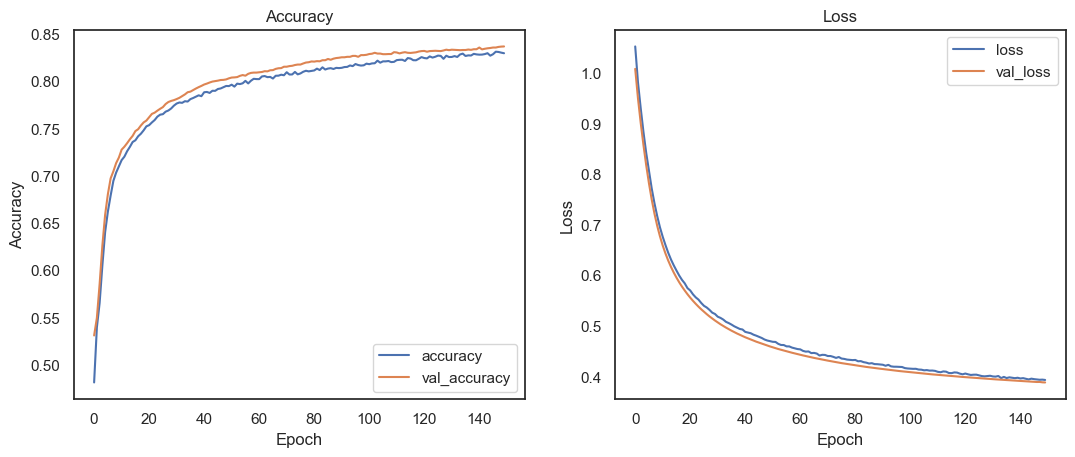

In [63]:
# Architecture 2: 32-256-3 Feed Forward Neural Network with 'relu' and 'softmax'
# Defining the ANN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(32, activation='relu', input_dim=input_dimension)) 
model.add(tf.keras.layers.Dense(256, activation='relu')) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(num_classes, activation='softmax')) 
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Stopping early to avoid overfitting
stop_callback = myCallback()
# Training
history = model.fit(x_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [64]:
# Evaluating the model on test data
test_loss_1, test_accuracy_1 = model.evaluate(x_test, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_1)
print('Test Accuracy:', test_accuracy_1)


Test Loss: 0.3880418837070465
Test Accuracy: 0.8367714285850525


Epoch 1/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0943 - accuracy: 0.4488 - val_loss: 1.0325 - val_accuracy: 0.4993
Epoch 2/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0652 - accuracy: 0.4761 - val_loss: 1.0294 - val_accuracy: 0.4993
Epoch 3/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0622 - accuracy: 0.4779 - val_loss: 1.0264 - val_accuracy: 0.4993
Epoch 4/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0625 - accuracy: 0.4764 - val_loss: 1.0231 - val_accuracy: 0.4993
Epoch 5/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0555 - accuracy: 0.4804 - val_loss: 1.0201 - val_accuracy: 0.4993
Epoch 6/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0545 - accuracy: 0.4784 - val_loss: 1.0173 - val_accuracy: 0.4993
Epoch 7/150
382/382 [==============================] - 1s 2ms/step - loss: 1.0487 - accuracy: 0.4843 - val_loss: 1.0145 - val_accuracy: 0.4993

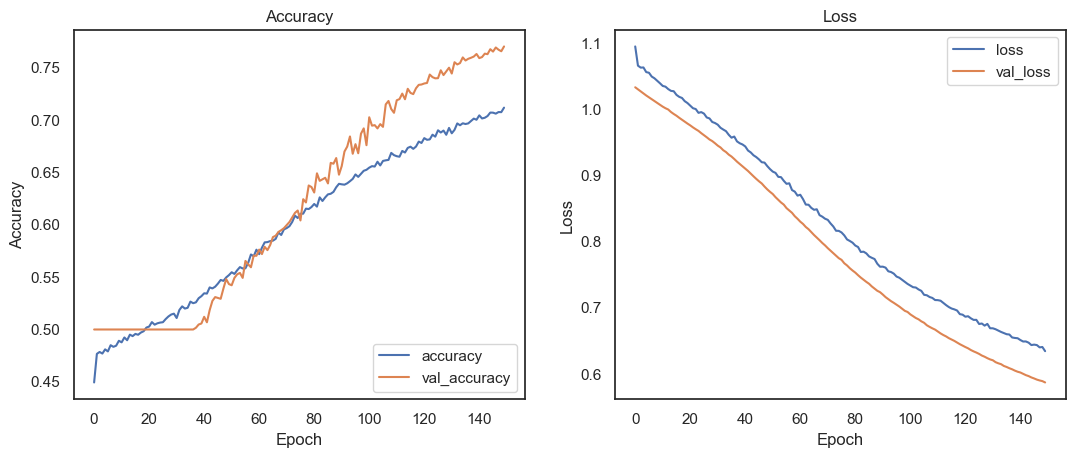

In [65]:
# Architecture 3: 32-256-3 Feed Forward Neural Network with 'sigmoid' and 'softmax'
# Defining the ANN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_dim=input_dimension)) 
model.add(tf.keras.layers.Dense(256, activation='sigmoid')) 
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(num_classes, activation='softmax')) 
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Stopping early to avoid overfitting
stop_callback = myCallback()
# Training
history = model.fit(x_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [66]:
# Evaluating the model on test data
test_loss_2, test_accuracy_2 = model.evaluate(x_test, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_2)
print('Test Accuracy:', test_accuracy_2)

Test Loss: 0.5863264799118042
Test Accuracy: 0.7696463465690613


* #### Neural Network 2: Recurrent Neural Network

Epoch 1/150
382/382 [==============================] - 3s 4ms/step - loss: 0.6001 - accuracy: 0.7196 - val_loss: 0.4233 - val_accuracy: 0.8137
Epoch 2/150
382/382 [==============================] - 1s 3ms/step - loss: 0.4067 - accuracy: 0.8164 - val_loss: 0.3836 - val_accuracy: 0.8294
Epoch 3/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3826 - accuracy: 0.8277 - val_loss: 0.3824 - val_accuracy: 0.8302
Epoch 4/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3722 - accuracy: 0.8349 - val_loss: 0.4183 - val_accuracy: 0.8076
Epoch 5/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3659 - accuracy: 0.8346 - val_loss: 0.3759 - val_accuracy: 0.8384
Epoch 6/150
382/382 [==============================] - 1s 4ms/step - loss: 0.3559 - accuracy: 0.8422 - val_loss: 0.3511 - val_accuracy: 0.8451
Epoch 7/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3442 - accuracy: 0.8503 - val_loss: 0.3394 - val_accuracy: 0.8517

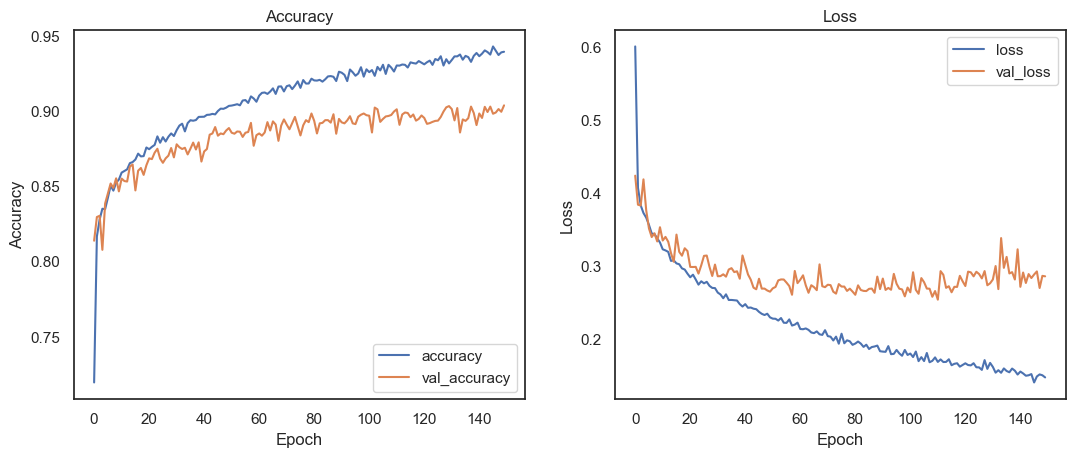

In [67]:
# Architecture 1: 32-64-128-3 RNN with 'relu' and 'softmax'
# Defining the RNN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(input_dimension, 1)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Stopping early to avoid overfitting
stop_callback = myCallback()
# Training
history = model.fit(x_train_reshaped, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test_reshaped, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [68]:
# Evaluating the model on test data
test_loss_3, test_accuracy_3 = model.evaluate(x_test_reshaped, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_3)
print('Test Accuracy:', test_accuracy_3)

Test Loss: 0.2856239378452301
Test Accuracy: 0.9035691022872925


Epoch 1/150
382/382 [==============================] - 2s 3ms/step - loss: 0.5892 - accuracy: 0.7242 - val_loss: 0.4039 - val_accuracy: 0.8255
Epoch 2/150
382/382 [==============================] - 1s 3ms/step - loss: 0.4042 - accuracy: 0.8153 - val_loss: 0.3811 - val_accuracy: 0.8332
Epoch 3/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3820 - accuracy: 0.8280 - val_loss: 0.3671 - val_accuracy: 0.8327
Epoch 4/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3672 - accuracy: 0.8357 - val_loss: 0.3610 - val_accuracy: 0.8353
Epoch 5/150
382/382 [==============================] - 2s 4ms/step - loss: 0.3562 - accuracy: 0.8394 - val_loss: 0.3561 - val_accuracy: 0.8420
Epoch 6/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3483 - accuracy: 0.8421 - val_loss: 0.3402 - val_accuracy: 0.8486
Epoch 7/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3397 - accuracy: 0.8483 - val_loss: 0.3424 - val_accuracy: 0.8476

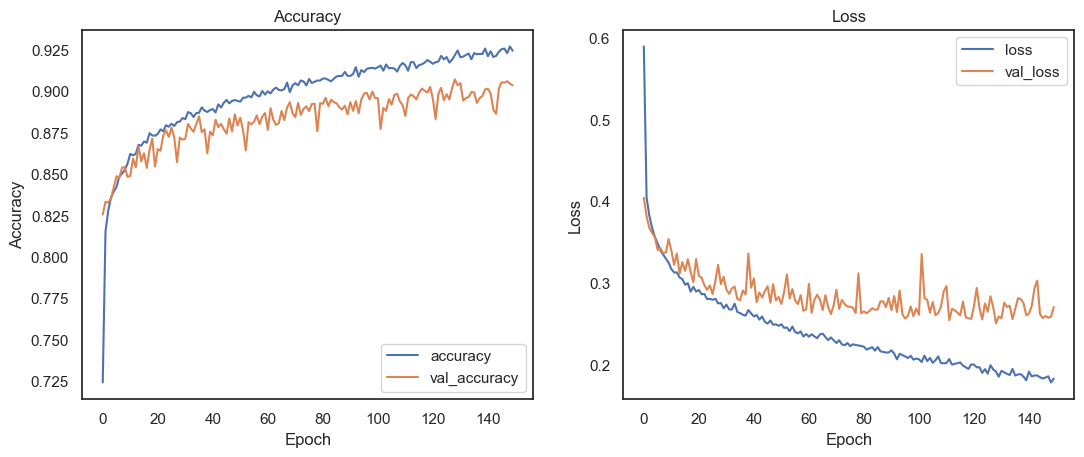

In [69]:
# Architecture 2: 32-256-3 RNN with 'relu' and 'softmax'
# Defining the RNN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(input_dimension, 1)))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Stopping early to avoid overfitting
stop_callback = myCallback()
# Training
history = model.fit(x_train_reshaped, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test_reshaped, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [70]:
# Evaluating the model on test data
test_loss_4, test_accuracy_4 = model.evaluate(x_test_reshaped, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_4)
print('Test Accuracy:', test_accuracy_4)
# Saving the model to a file
model.save('RNN.h5')

Test Loss: 0.2702840268611908
Test Accuracy: 0.9034053683280945


Epoch 1/150
382/382 [==============================] - 3s 5ms/step - loss: 0.5702 - accuracy: 0.7319 - val_loss: 0.4756 - val_accuracy: 0.7852
Epoch 2/150
382/382 [==============================] - 1s 4ms/step - loss: 0.4305 - accuracy: 0.8026 - val_loss: 0.4309 - val_accuracy: 0.7965
Epoch 3/150
382/382 [==============================] - 1s 4ms/step - loss: 0.4059 - accuracy: 0.8168 - val_loss: 0.3873 - val_accuracy: 0.8258
Epoch 4/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3911 - accuracy: 0.8229 - val_loss: 0.4075 - val_accuracy: 0.8129
Epoch 5/150
382/382 [==============================] - 1s 4ms/step - loss: 0.3817 - accuracy: 0.8275 - val_loss: 0.4011 - val_accuracy: 0.8166
Epoch 6/150
382/382 [==============================] - 1s 4ms/step - loss: 0.3732 - accuracy: 0.8313 - val_loss: 0.3859 - val_accuracy: 0.8346
Epoch 7/150
382/382 [==============================] - 1s 3ms/step - loss: 0.3624 - accuracy: 0.8365 - val_loss: 0.3730 - val_accuracy: 0.8302

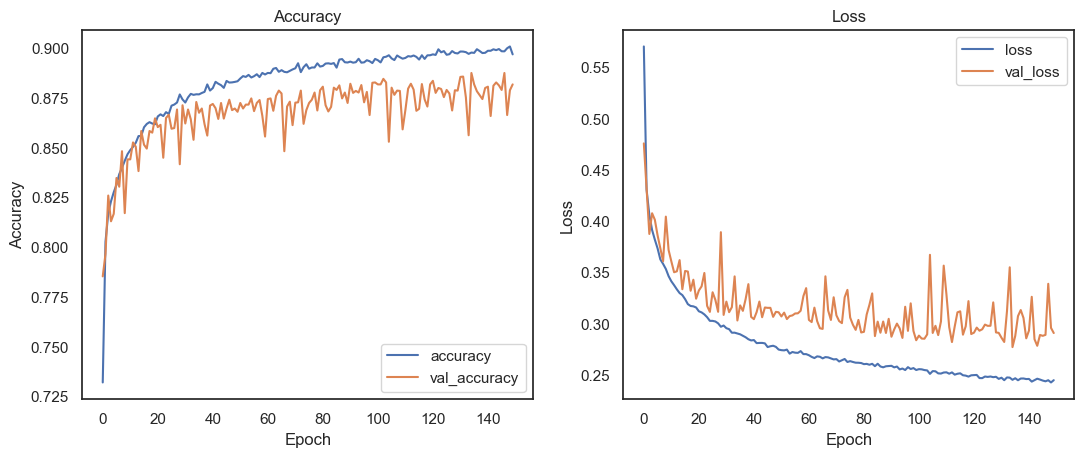

In [71]:
# Architecture 3: 32-265-3 RNN with 'sigmoid', 'tanh and 'softmax'
# Defining the RNN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(input_dimension, 1)))
model.add(tf.keras.layers.Dense(256, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Model Compilation
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Stopping early to avoid overfitting
stop_callback = myCallback()
# Training
history = model.fit(x_train_reshaped, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_data=(x_test_reshaped, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [72]:
# Evaluating the model on test data
test_loss_5, test_accuracy_5 = model.evaluate(x_test_reshaped, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_5)
print('Test Accuracy:', test_accuracy_5)

Test Loss: 0.2906218469142914
Test Accuracy: 0.8816306591033936


In [73]:
# Results
print("Testing Performances for Deep Learning Algorithms on 150 Epochs")
result = pd.DataFrame({"Algorithms":['64-64-128-3 Feed Forward Neural Network', "32-256-3 Feed Forward Neural Network", "32-256-3 Feed Forward Neural Network", "32-64-128-3 Recurrent Neural Network", "32-256-3 Recurrent Neural Network", "32-256-3 Recurrent Neural Network"],
                       "Activation Functions":["relu", "relu","sigmoid", "relu","relu", "relu & tanh"],
                       "Optimizers":["Adam","SGD","SGD","Adam","Adam", "RMSprop"],
                       "Accuracy":[round(test_accuracy_0,3), round(test_accuracy_1,3), round(test_accuracy_2,3), round(test_accuracy_3,3), round(test_accuracy_4,3), round(test_accuracy_5,3)],
                       "Loss":[round(test_loss_0,3), round(test_loss_1,3), round(test_loss_2,3), round(test_loss_3,3), round(test_loss_4,3), round(test_loss_5,3)]}).set_index('Algorithms')
result

Testing Performances for Deep Learning Algorithms on 150 Epochs


,Activation Functions,Optimizers,Accuracy,Loss
Algorithms,,,,
64-64-128-3 Feed Forward Neural Network,relu,Adam,0.911,0.253
32-256-3 Feed Forward Neural Network,relu,SGD,0.837,0.388
32-256-3 Feed Forward Neural Network,sigmoid,SGD,0.770,0.586
32-64-128-3 Recurrent Neural Network,relu,Adam,0.904,0.286
32-256-3 Recurrent Neural Network,relu,Adam,0.903,0.270
32-256-3 Recurrent Neural Network,relu & tanh,RMSprop,0.882,0.291
